# Load packages

In [94]:
import warnings
warnings.filterwarnings('ignore')

In [95]:
import tsai
from tsai.all import *
print('tsai       :', tsai.__version__)
print('fastai     :', fastai.__version__)
print('fastcore   :', fastcore.__version__)
print('torch      :', torch.__version__)

tsai       : 0.2.17
fastai     : 2.3.1
fastcore   : 1.3.19
torch      : 1.8.1+cu111


In [96]:
torch.cuda.get_device_name(0)

'GeForce RTX 2070'

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from matplotlib import ticker

In [98]:
large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
           'legend.fontsize': med,
           'figure.figsize': (10, 6),
           'axes.labelsize': med,
           'axes.titlesize': med,
           'xtick.labelsize': med,
           'ytick.labelsize': med,
           'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
%matplotlib inline

# Version
print(mpl.__version__)
print(sns.__version__)

3.3.2
0.11.0


In [99]:
import hyperopt
print(hyperopt.__version__)
from hyperopt import Trials, STATUS_OK, STATUS_FAIL, tpe, fmin, hp
from hyperopt import space_eval

0.2.5


In [100]:
import time
from fastai.callback.tracker import EarlyStoppingCallback
import gc

In [101]:
import pickle
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Specify parameters

In [102]:
file_name = "../OD_pair/GEANT-OD_pair.csv"  # the input filename
history = 10  # input historical time steps
horizon = 1  # output predicted time steps
test_ratio = 0.2  # testing data ratio
max_evals = 100  # maximal trials for hyper parameter tuning

model_name = 'LSTM'
y_true_fn = '%s_true_TM-minmax-%d-%d.pkl' % (model_name, history, horizon)
y_pred_fn = '%s_pred_TM-minmax-%d-%d.pkl' % (model_name, history, horizon)

RMSE_fn = model_name + '_TM-minmax_RMSE-%d-%d-step-%d.pdf'
MAE_fn = model_name + '_TM-minmax_MAE-%d-%d-step-%d.pdf'

In [103]:
y_true_fn

'LSTM_true_TM-minmax-10-1.pkl'

In [104]:
y_pred_fn

'LSTM_pred_TM-minmax-10-1.pkl'

# Load data

In [105]:
df = pd.read_csv(file_name)

In [106]:
df.head()

time  OD_1-1       OD_1-2        OD_1-3        OD_1-4  \
0  2005-05-04-15-30     0.0  16760.79111  12407.777780  10453.848890   
1  2005-05-04-15-45     0.0  16346.46222   9373.208889   8439.048889   
2  2005-05-04-16-00     0.0  16755.22667  10638.302220  12623.520000   
3  2005-05-04-16-15     0.0  18488.00889  12263.697780  13389.128890   
4  2005-05-04-16-30     0.0  13748.27556  11323.333330  14048.426670   

        OD_1-5       OD_1-6       OD_1-7       OD_1-8       OD_1-9  ...  \
0  1468.631111  4768.444444  25290.37333  2468.515556  7984.213333  ...   
1  1032.906667  1649.520000  14433.05778  3182.986667  7243.173333  ...   
2   721.226667  1693.057778  17066.67556  5304.195556  6696.844444  ...   
3   995.600000  2984.231111  13325.22667  6248.248889  5719.804444  ...   
4   804.044444  2698.124444  16651.25333  5761.528889  5088.204444  ...   

   OD_23-14    OD_23-15     OD_23-16     OD_23-17     OD_23-18     OD_23-19  \
0       0.0  211.395556  1212.666667  1026.391111  51508.78222  1488.951111   
1       0.0  190.142222  1079.751111   529.617778  44913.43111  1410.400000   
2       0.0   51.048889  1750.631111    81.760000  47603.85778  1016.977778   
3       0.0  217.911111  3313.120000   356.000000  47023.99111  1092.017778   
4       0.0  292.071111  4479.644444   541.288889  47737.10222  1139.217778   

      OD_23-20     OD_23-21   OD_23-22  OD_23-23  
0  175293.2444  3247.164444  14.106667       0.0  
1  148162.8711  3669.173333   6.880000       0.0  
2  154312.8711  3452.320000  24.488889       0.0  
3  148199.6622  3300.613333  36.951111       0.0  
4  147601.5467  4073.137778  59.848889       0.0  

[5 rows x 530 columns]

Parse the time column:

In [107]:
df['time'] = pd.to_datetime(df['time'], format='%Y-%m-%d-%H-%M')  # Parse the time

Remove the outliers:

In [108]:
data_columns = list(df.columns.values)
data_columns.remove('time')
data = df[data_columns].values
data = np.clip(data, 0.0, np.percentile(data.flatten(), 99))  # we use 99% as the threshold
df[data_columns] = data

# Split the data

Split the data based on the test_ratio parameter. Aggreate the data and plot the training/testing split first:

In [109]:
aggregated_time_series = np.sum(data, axis=1)
df_ts = pd.DataFrame()
df_ts['date'] = df['time']
df_ts['data'] = aggregated_time_series / 1000  # Plot in Mbps

# add a datetimeindex
dates = pd.DatetimeIndex(df_ts['date'])
df_ts = df_ts.set_index(dates).asfreq('15T') 

In [110]:
test_length = int(df.shape[0] * test_ratio)
train_length = df.shape[0] - test_length

In [111]:
df_ts.index[train_length:][0]

Timestamp('2005-08-02 09:30:00', freq='15T')

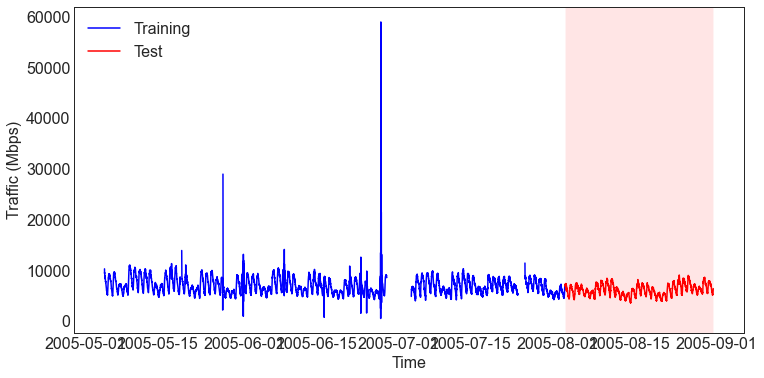

In [112]:
plt.figure(figsize=[12, 6])
plt.plot(df_ts.index[:train_length], df_ts['data'][:train_length], label='Training', color='blue')
plt.plot(df_ts.index[train_length:], df_ts['data'][train_length:], label='Test', color='red')
plt.axvspan(df_ts.index[train_length:][0], df_ts.index[train_length:][-1],  facecolor='r', alpha=0.1)

plt.xlabel('Time')
plt.ylabel('Traffic (Mbps)')
plt.legend(loc='best')
# plt.show()
plt.savefig('training_test_split.pdf', bbox_inches = 'tight', pad_inches = 0.1)

Plot the training / testing split:

# Normalize the data

Calculate the min and max data based on the training data set:

In [20]:
max_list = np.max(data[:train_length], axis=0)

In [21]:
min_list = np.min(data[:train_length], axis=0)

Normalize the data and fill the data:

In [22]:
data = (data - min_list) / (max_list - min_list)
data[np.isnan(data)] = 0  # fill the abnormal data with 0
data[np.isinf(data)] = 0

In [23]:
print(np.max(data[:train_length].flatten()))

1.0


In [24]:
print(np.min(data[:train_length].flatten()))

0.0


The training data is in a range of [0, 1] but the test data may be out of this range:

In [25]:
print(np.max(data.flatten()))

4.931113265982958


In [26]:
print(np.min(data.flatten()))

-0.003975552580138194


# Build the supervised prediction problem

The input data is in the following format:
* x_data as input features: [data size, input historical steps, input channels]. Here the input channel number is the OD pair number.
* y_data as output targets: [data size, output prediction steps, output channels].

In [27]:
x_data = []
y_data = []

In [28]:
length = data.shape[0]
print(length)

10769


In [29]:
for i in range(length - history - horizon + 1):
    x = data[i:i+history, :]  # input historical time steps
    y = data[i+history:i+history+horizon:, :]  # output predicted time steps
    x_data.append(x)
    y_data.append(y)

In [30]:
x_data = np.array(x_data)
y_data = np.array(y_data)

In [31]:
x_data.shape

(10759, 10, 529)

In [32]:
y_data.shape

(10759, 1, 529)

Reshape x_data:

In [33]:
x_data = np.swapaxes(x_data, 1, 2)

**This format is required by tsai: [data size, input channels, input historical steps].**

Reshape y_data:

In [34]:
y_data = y_data.reshape(y_data.shape[0], -1)
y_data.shape

(10759, 529)

The last test_length samples are fixed as test data. The training data size may vary with the input historical time steps. The test data size may vary with the prediction horizon.

In [35]:
test_length = test_length - horizon + 1

In [36]:
train_valid_length = x_data.shape[0] - test_length

In [37]:
train_valid_length

8606

We further split a valid data set for hyper parameter tuning:

In [38]:
train_length = int(train_valid_length * 0.8)
valid_length = train_valid_length - train_length

In [39]:
train_length

6884

In [40]:
valid_length

1722

In [41]:
X_train = x_data[:train_length]
y_train = y_data[:train_length]
X_valid = x_data[train_length:train_valid_length]
y_valid = y_data[train_length:train_valid_length]
X_test = x_data[train_valid_length:]
y_test = y_data[train_valid_length:]

In [42]:
X_train.shape

(6884, 529, 10)

In [43]:
y_train.shape

(6884, 529)

In [44]:
X_valid.shape

(1722, 529, 10)

In [45]:
y_valid.shape

(1722, 529)

In [46]:
X_test.shape

(2153, 529, 10)

In [47]:
y_test.shape

(2153, 529)

# Build TSAI Datasets

Now we are ready to use the tsai package with its dataset definition:

In [48]:
X, y, splits = combine_split_data([X_train, X_valid], [y_train, y_valid])

In [49]:
X.shape

(8606, 529, 10)

In [50]:
y.shape

(8606, 529)

In [51]:
splits

((#6884) [0,1,2,3,4,5,6,7,8,9...],
 (#1722) [6884,6885,6886,6887,6888,6889,6890,6891,6892,6893...])

Make sure this is a regression task, instead of a classification task (using TSRegression as follows):

In [52]:
tfms  = [None, [TSRegression()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
dsets

(#8606) [(TSTensor(vars:529, len:10), tensor([0.0000e+00, 8.9423e-02, 3.7106e-01, 1.0264e-01, 7.2026e-02, 3.4304e-03,
        7.1890e-02, 1.2682e-02, 2.5281e-02, 9.1491e-03, 5.0183e-03, 1.2151e-01,
        0.0000e+00, 5.6280e-05, 1.8669e-02, 3.2046e-01, 3.0214e-02, 4.0630e-01,
        5.0114e-02, 6.6921e-02, 1.0054e-04, 0.0000e+00, 2.1455e-01, 0.0000e+00,
        7.3656e-01, 2.4451e-03, 1.4999e-02, 9.5933e-04, 1.4186e-01, 9.6139e-03,
        7.5581e-03, 5.6137e-01, 1.3439e-03, 7.8781e-03, 4.1034e-02, 1.0031e-02,
        5.2605e-03, 3.9400e-03, 5.2090e-02, 4.1799e-03, 2.3216e-02, 6.7784e-02,
        3.5897e-02, 1.7727e-01, 4.3577e-03, 5.7287e-01, 0.0000e+00, 7.6272e-02,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 3.0254e-04, 6.5089e-03, 1.7143e-03,
        1.1740e-01, 4.1891e-02, 7.4133e-03, 1.8199e-02, 1.3436e-02, 1.7860e-04,
        1.5109e-02, 1.5142e-02, 7.8321e-04, 1.5964e-02, 9.8029e-04, 2.2297e-02,
        8.7682e-02, 7.0101e-04, 8.7537e-03, 0.0000e+00, 2.1880e-01, 0.0000e+00,
  

# Model Building and Hyperparameter Tuning

We use the hyperopt package to search for hyper parameters:

In [53]:
search_space = {
    'batch_size': hp.choice('bs', [16, 32, 64, 128]),
    "lr": hp.choice('lr', [0.01, 0.001, 0.0001]),
    "epochs": hp.choice('epochs', [20, 50, 100]),  # we would also use early stopping
    "patience": hp.choice('patience', [5, 10]),  # early stopping patience
    # "optimizer": hp.choice('optimizer', [Adam, SGD, RMSProp]),  # https://docs.fast.ai/optimizer
    "optimizer": hp.choice('optimizer', [Adam]),
    # model parameters
    "n_layers": hp.choice('n_layers', [1, 2, 3, 4, 5]),
    "hidden_size": hp.choice('hidden_size', [50, 100, 200]),
    "bidirectional": hp.choice('bidirectional', [True, False])
}

In [54]:
search_space

{'batch_size': <hyperopt.pyll.base.Apply at 0x1c0dd90c148>,
 'lr': <hyperopt.pyll.base.Apply at 0x1c0dd90c888>,
 'epochs': <hyperopt.pyll.base.Apply at 0x1c0dd90cbc8>,
 'patience': <hyperopt.pyll.base.Apply at 0x1c0eb118988>,
 'optimizer': <hyperopt.pyll.base.Apply at 0x1c080142fc8>,
 'n_layers': <hyperopt.pyll.base.Apply at 0x1c0dd8cf288>,
 'hidden_size': <hyperopt.pyll.base.Apply at 0x1c0dd8cf8c8>,
 'bidirectional': <hyperopt.pyll.base.Apply at 0x1c0b3231b88>}

In [55]:
# clear memory 
gc.collect()

40

In [56]:
def create_model_hypopt(params):
    
    try:
        # clear memory 
        gc.collect()
        print("Trying params:", params)
        batch_size = params["batch_size"]
    
        # Create data loader
        tfms  = [None, [TSRegression()]]
        dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
        # set num_workers for memory bottleneck
        dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[batch_size, batch_size], num_workers=0)
    
        # Create model
        arch = LSTM
        k = {
            'n_layers': params['n_layers'],
            'hidden_size': params['hidden_size'],
            'bidirectional': params['bidirectional']
        }
        model = create_model(arch, dls=dls, **k)
        print(model.__class__.__name__)
        
        # Add a Sigmoid layer
        model = nn.Sequential(model, nn.Sigmoid())
    
        # Training the model
        learn = Learner(dls, model, metrics=[mae, rmse], opt_func=params['optimizer'])
        start = time.time()
        learn.fit_one_cycle(params['epochs'], lr_max=params['lr'],
                            cbs=EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0, patience=params['patience']))
        learn.plot_metrics()
        elapsed = time.time() - start
        print(elapsed)
    
        vals = learn.recorder.values[-1]
        print(vals)
        # vals[0], vals[1], vals[2]
        # train loss, valid loss, accuracy
        val_loss = vals[1]
    
        # delete tmp variables
        del dls
        del model
        del learn
        return {'loss': val_loss, 'status': STATUS_OK} # if accuracy use '-' sign, model is optional
    except:
        return {'loss': None, 'status': STATUS_FAIL}

Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': False, 'epochs': 20, 'hidden_size': 200, 'lr': 0.0001, 'n_layers': 4, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 5}
LSTM                                                                                                                   
  0%|                                                                          | 0/100 [00:03<?, ?trial/s, best loss=?]

No improvement since epoch 9: early stopping                                                                           
  0%|                                                                          | 0/100 [01:14<?, ?trial/s, best loss=?]

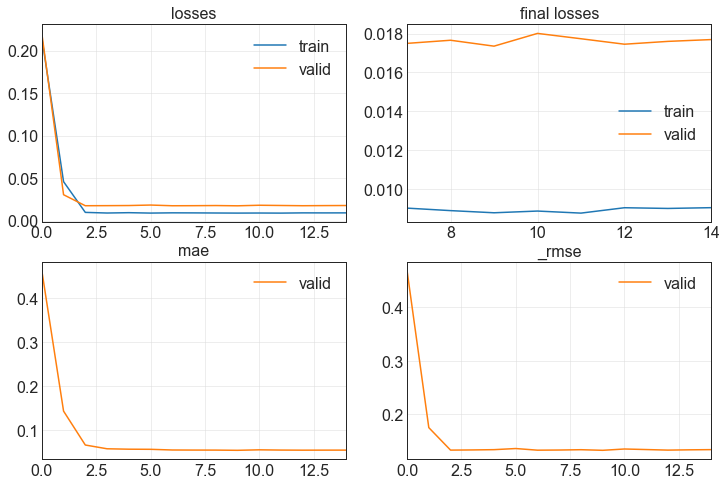

70.87882399559021                                                                                                      
[0.009040352888405323, 0.017689762637019157, 0.05487164482474327, 0.1330028474330902]                                  
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 20, 'hidden_size': 50, 'lr': 0.01, 'n_layers': 3, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 5}
LSTM                                                                                                                   
  1%|▍                                           | 1/100 [01:16<2:03:05, 74.60s/trial, best loss: 0.017689762637019157]

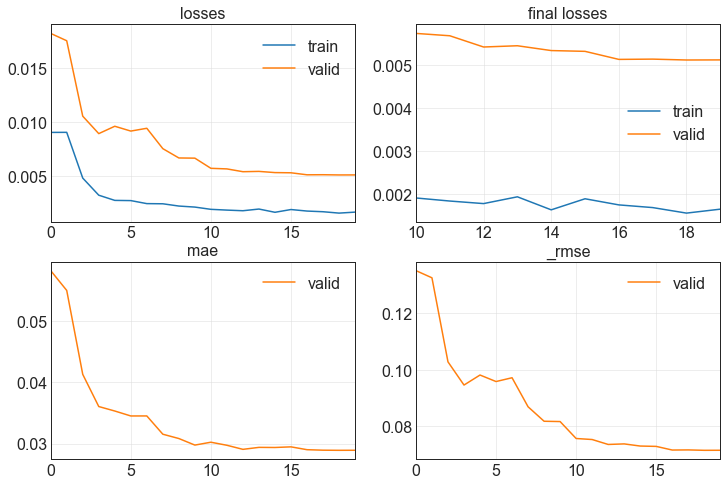

105.65493106842041                                                                                                     
[0.0016598249785602093, 0.005114756058901548, 0.028900884091854095, 0.07151751965284348]                               
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': False, 'epochs': 50, 'hidden_size': 50, 'lr': 0.0001, 'n_layers': 5, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 5}
LSTM                                                                                                                   
  2%|▉                                           | 2/100 [03:03<2:17:48, 84.37s/trial, best loss: 0.005114756058901548]

No improvement since epoch 21: early stopping                                                                          
  2%|▉                                           | 2/100 [04:02<2:17:48, 84.37s/trial, best loss: 0.005114756058901548]

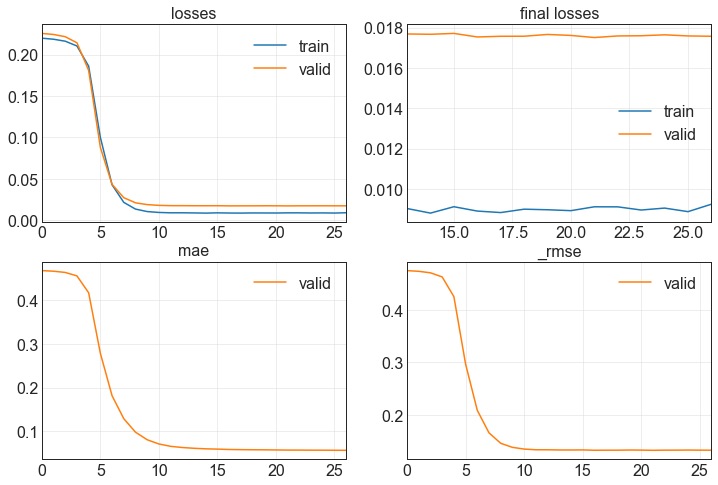

60.074063539505005                                                                                                     
[0.009240293875336647, 0.017566489055752754, 0.056145571172237396, 0.13253863155841827]                                
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 50, 'hidden_size': 100, 'lr': 0.0001, 'n_layers': 3, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 5}
LSTM                                                                                                                   
  3%|█▎                                          | 3/100 [04:04<2:05:19, 77.52s/trial, best loss: 0.005114756058901548]

No improvement since epoch 6: early stopping                                                                           
  3%|█▎                                          | 3/100 [05:06<2:05:19, 77.52s/trial, best loss: 0.005114756058901548]

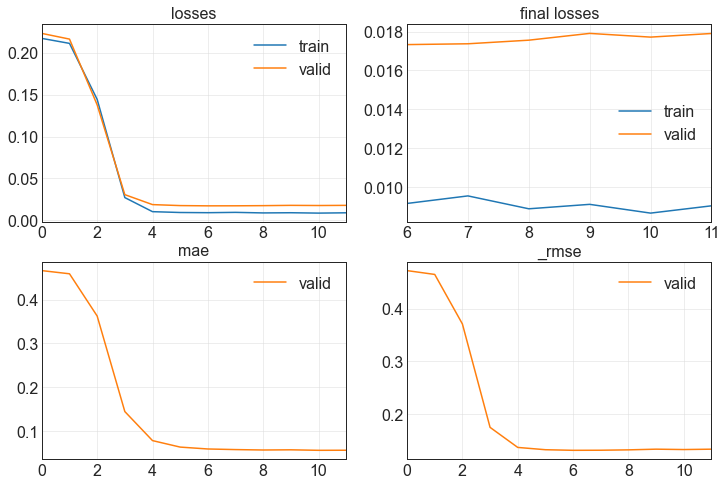

61.79480695724487                                                                                                      
[0.009032580070197582, 0.01789875701069832, 0.055700406432151794, 0.13378621637821198]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 20, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 2, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 5}
LSTM                                                                                                                   
  4%|█▊                                          | 4/100 [05:08<1:57:12, 73.25s/trial, best loss: 0.005114756058901548]

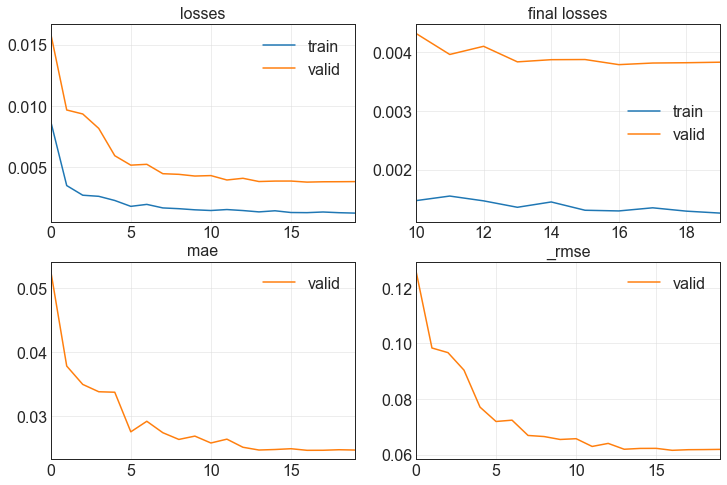

93.99828290939331                                                                                                      
[0.001260064309462905, 0.003829583991318941, 0.024750003591179848, 0.061883628368377686]                               
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': False, 'epochs': 100, 'hidden_size': 200, 'lr': 0.0001, 'n_layers': 2, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 5}
LSTM                                                                                                                   
  5%|██▏                                         | 5/100 [06:43<2:06:31, 79.91s/trial, best loss: 0.003829583991318941]

No improvement since epoch 33: early stopping                                                                          
  5%|██▏                                         | 5/100 [07:22<2:06:31, 79.91s/trial, best loss: 0.003829583991318941]

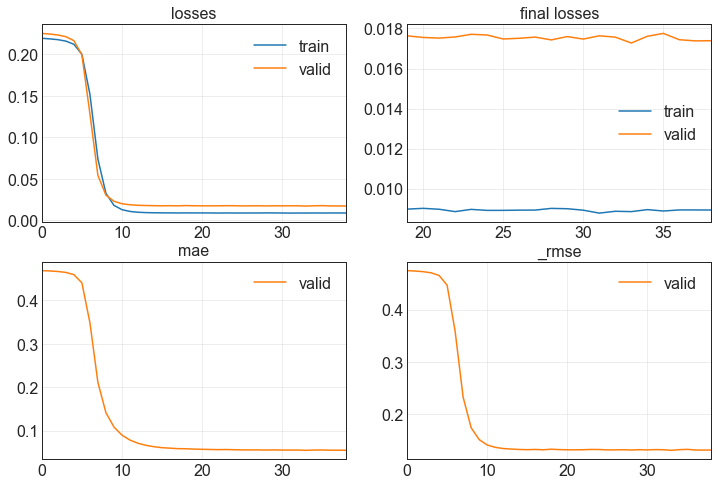

39.73878479003906                                                                                                      
[0.008933459408581257, 0.017391618341207504, 0.05466381832957268, 0.13187728822231293]                                 
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': False, 'epochs': 100, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 1, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 10}
LSTM                                                                                                                   
  6%|██▋                                         | 6/100 [07:24<1:46:59, 68.29s/trial, best loss: 0.003829583991318941]

No improvement since epoch 88: early stopping                                                                          
  6%|██▋                                         | 6/100 [08:10<1:46:59, 68.29s/trial, best loss: 0.003829583991318941]

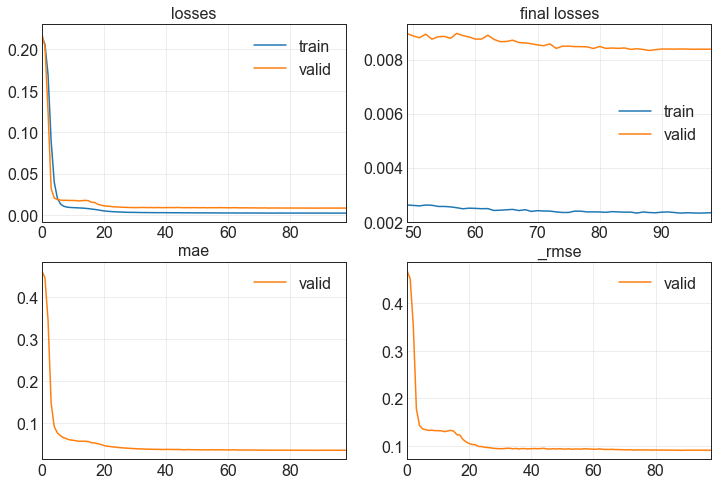

46.204633474349976                                                                                                     
[0.0023363777436316013, 0.008383107371628284, 0.03492439165711403, 0.09155931323766708]                                
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': False, 'epochs': 50, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 10}
LSTM                                                                                                                   
  7%|███                                         | 7/100 [08:12<1:36:16, 62.11s/trial, best loss: 0.003829583991318941]

No improvement since epoch 38: early stopping                                                                          
  7%|███                                         | 7/100 [08:34<1:36:16, 62.11s/trial, best loss: 0.003829583991318941]

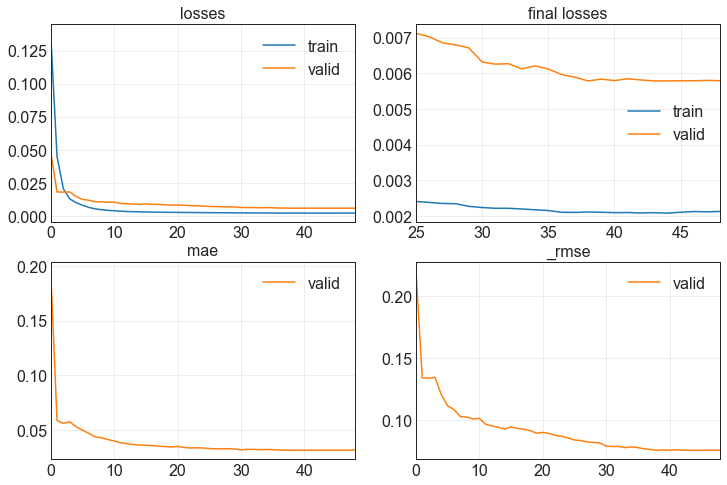

22.711675882339478                                                                                                     
[0.002123843180015683, 0.0057878680527210236, 0.03176979720592499, 0.07607804238796234]                                
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': True, 'epochs': 20, 'hidden_size': 50, 'lr': 0.001, 'n_layers': 5, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 10}
LSTM                                                                                                                   
  8%|███▌                                        | 8/100 [08:36<1:17:48, 50.74s/trial, best loss: 0.003829583991318941]

No improvement since epoch 5: early stopping                                                                           
  8%|███▌                                        | 8/100 [08:52<1:17:48, 50.74s/trial, best loss: 0.003829583991318941]

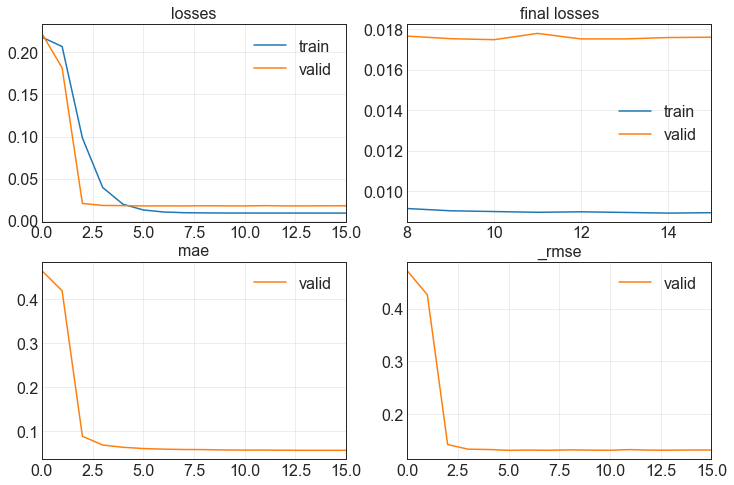

16.467872381210327                                                                                                     
[0.008938439190387726, 0.017596978694200516, 0.05584746599197388, 0.13265360891819]                                    
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 50, 'hidden_size': 200, 'lr': 0.0001, 'n_layers': 2, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 10}
LSTM                                                                                                                   
  9%|███▉                                        | 9/100 [08:54<1:02:02, 40.91s/trial, best loss: 0.003829583991318941]

No improvement since epoch 31: early stopping                                                                          
  9%|███▉                                        | 9/100 [12:11<1:02:02, 40.91s/trial, best loss: 0.003829583991318941]

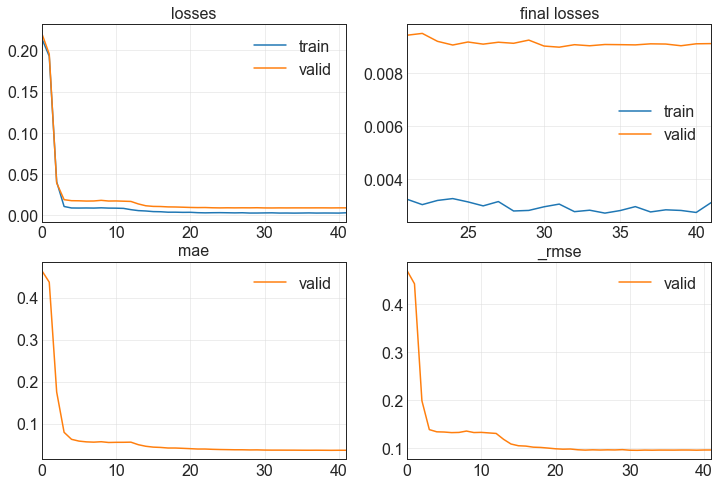

197.3381643295288                                                                                                      
[0.00313388230279088, 0.009112085215747356, 0.036470115184783936, 0.09545724093914032]                                 
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'epochs': 100, 'hidden_size': 50, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 5}
LSTM                                                                                                                   
 10%|████▎                                      | 10/100 [12:13<2:12:23, 88.26s/trial, best loss: 0.003829583991318941]

No improvement since epoch 21: early stopping                                                                          
 10%|████▎                                      | 10/100 [12:56<2:12:23, 88.26s/trial, best loss: 0.003829583991318941]

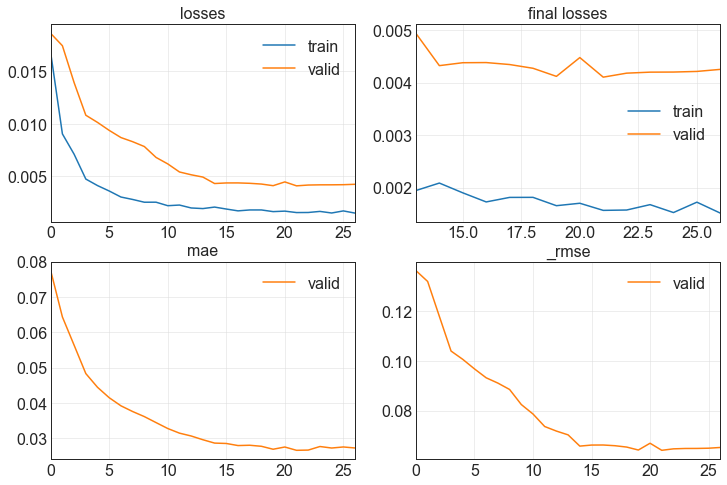

44.08792471885681                                                                                                      
[0.00151231384370476, 0.004250946920365095, 0.027294917032122612, 0.06519928574562073]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 50, 'hidden_size': 50, 'lr': 0.01, 'n_layers': 2, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 5}
LSTM                                                                                                                   
 11%|████▋                                      | 11/100 [12:58<1:51:57, 75.47s/trial, best loss: 0.003829583991318941]

No improvement since epoch 29: early stopping                                                                          
 11%|████▋                                      | 11/100 [15:27<1:51:57, 75.47s/trial, best loss: 0.003829583991318941]

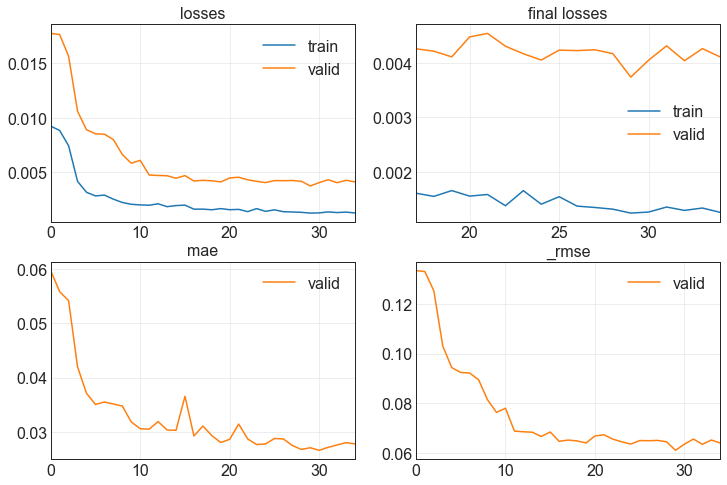

148.73917603492737                                                                                                     
[0.001256157411262393, 0.004108636640012264, 0.027804052457213402, 0.06409864127635956]                                
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': False, 'epochs': 50, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 2, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 5}
LSTM                                                                                                                   
 12%|█████▏                                     | 12/100 [15:29<2:23:35, 97.90s/trial, best loss: 0.003829583991318941]

No improvement since epoch 8: early stopping                                                                           
 12%|█████▏                                     | 12/100 [15:42<2:23:35, 97.90s/trial, best loss: 0.003829583991318941]

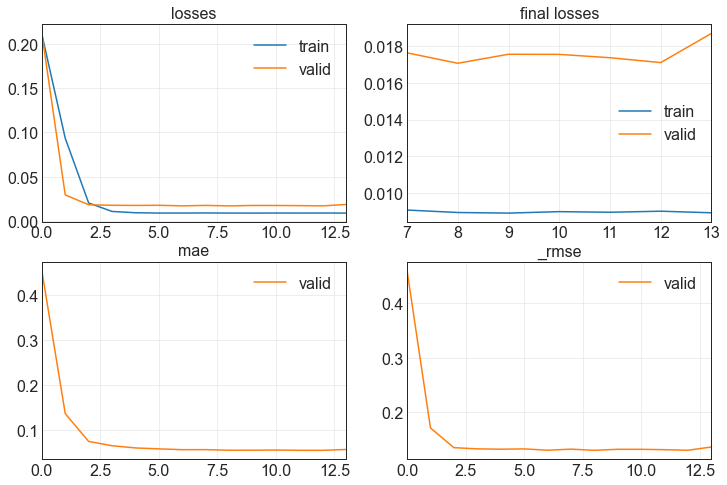

14.2823805809021                                                                                                       
[0.008932809345424175, 0.01868428662419319, 0.05600940063595772, 0.13669048249721527]                                  
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': False, 'epochs': 20, 'hidden_size': 200, 'lr': 0.0001, 'n_layers': 3, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 5}
LSTM                                                                                                                   
 13%|█████▌                                     | 13/100 [15:44<1:46:13, 73.26s/trial, best loss: 0.003829583991318941]

No improvement since epoch 6: early stopping                                                                           
 13%|█████▌                                     | 13/100 [16:31<1:46:13, 73.26s/trial, best loss: 0.003829583991318941]

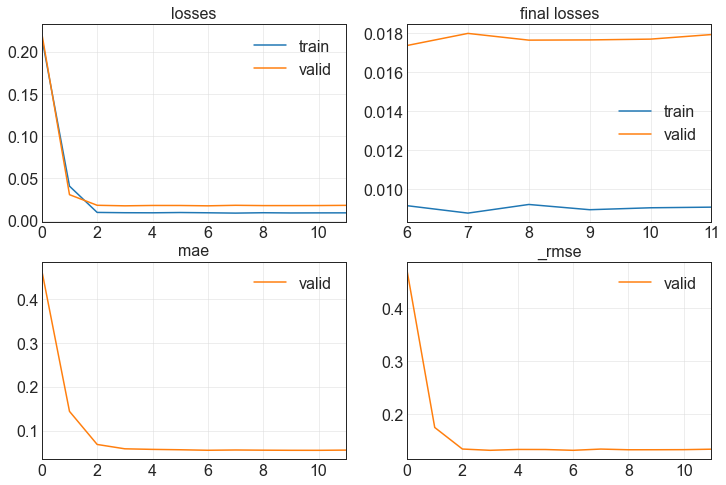

47.50963354110718                                                                                                      
[0.00906140822917223, 0.017940420657396317, 0.05542468652129173, 0.13394184410572052]                                  
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': False, 'epochs': 50, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 1, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 10}
LSTM                                                                                                                   
 14%|██████                                     | 14/100 [16:33<1:34:33, 65.97s/trial, best loss: 0.003829583991318941]

No improvement since epoch 33: early stopping                                                                          
 14%|██████                                     | 14/100 [17:36<1:34:33, 65.97s/trial, best loss: 0.003829583991318941]

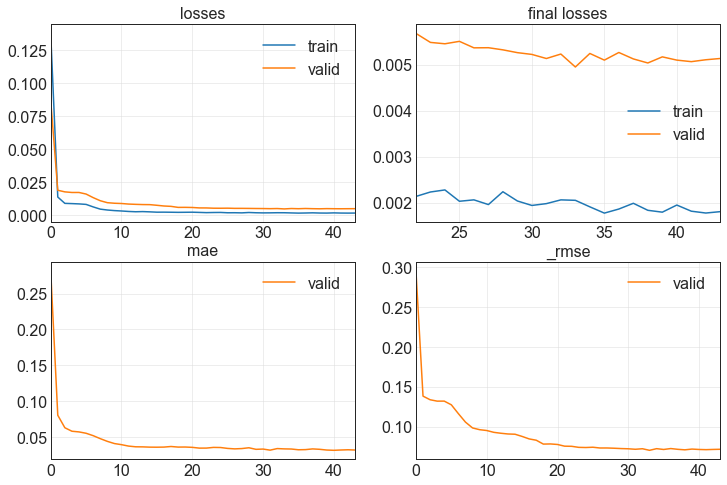

63.11532688140869                                                                                                      
[0.0018032437656074762, 0.005134398117661476, 0.031433284282684326, 0.07165471464395523]                               
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 20, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 5, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 10}
LSTM                                                                                                                   
 15%|██████▍                                    | 15/100 [17:38<1:32:51, 65.54s/trial, best loss: 0.003829583991318941]

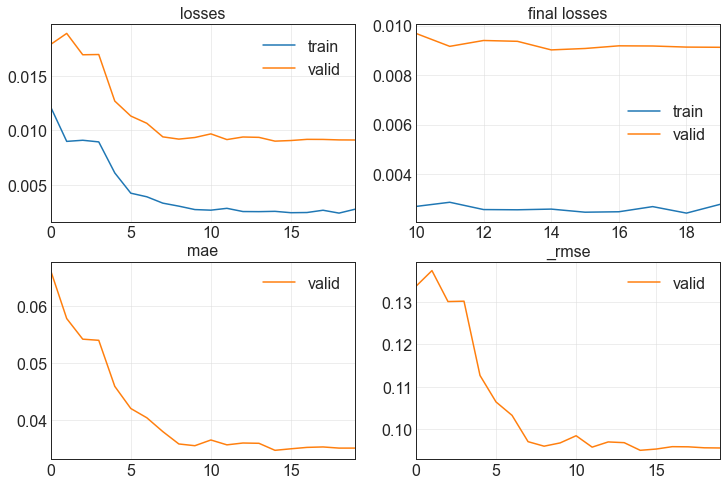

172.24863362312317                                                                                                     
[0.002777733141556382, 0.00912323035299778, 0.035148363560438156, 0.09551560133695602]                                 
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': True, 'epochs': 50, 'hidden_size': 50, 'lr': 0.01, 'n_layers': 2, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 10}
LSTM                                                                                                                   
 16%|██████▉                                    | 16/100 [20:32<2:17:14, 98.02s/trial, best loss: 0.003829583991318941]

No improvement since epoch 38: early stopping                                                                          
 16%|██████▉                                    | 16/100 [21:26<2:17:14, 98.02s/trial, best loss: 0.003829583991318941]

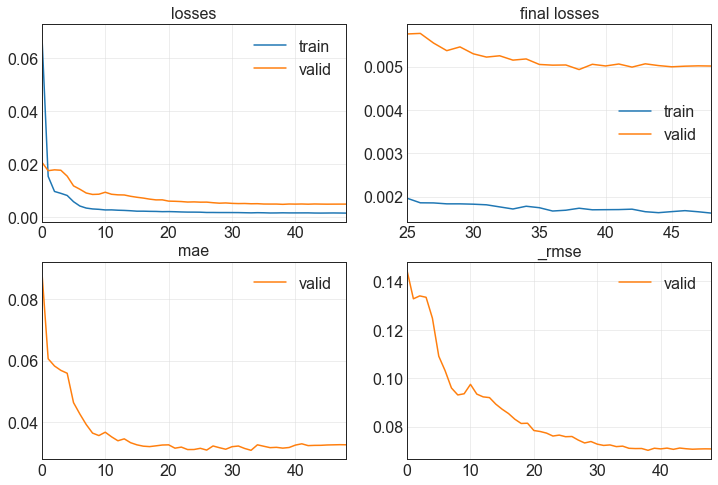

54.446361780166626                                                                                                     
[0.0016179950907826424, 0.00501138623803854, 0.032769281417131424, 0.07079114764928818]                                
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 100, 'hidden_size': 100, 'lr': 0.0001, 'n_layers': 1, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 10}
LSTM                                                                                                                   
 17%|███████▎                                   | 17/100 [21:28<1:58:06, 85.38s/trial, best loss: 0.003829583991318941]

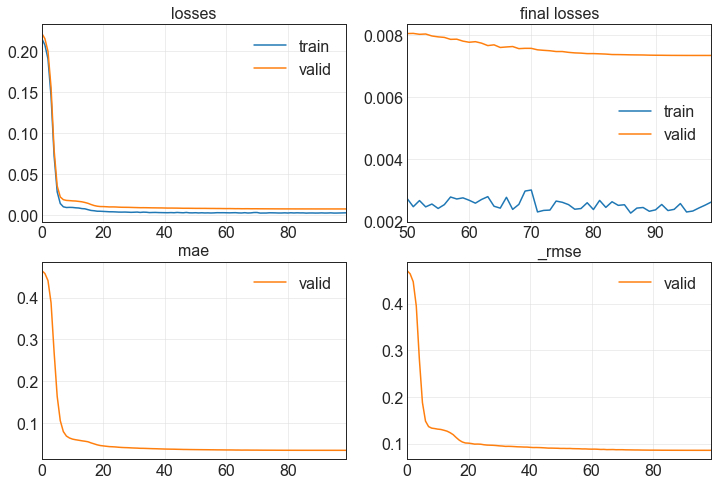

317.80532145500183                                                                                                     
[0.00263199838809669, 0.007351566106081009, 0.03399281203746796, 0.08574126660823822]                                  
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': False, 'epochs': 100, 'hidden_size': 50, 'lr': 0.001, 'n_layers': 5, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 10}
LSTM                                                                                                                   
 18%|███████▌                                  | 18/100 [26:47<3:32:33, 155.52s/trial, best loss: 0.003829583991318941]

No improvement since epoch 11: early stopping                                                                          
 18%|███████▌                                  | 18/100 [27:36<3:32:33, 155.52s/trial, best loss: 0.003829583991318941]

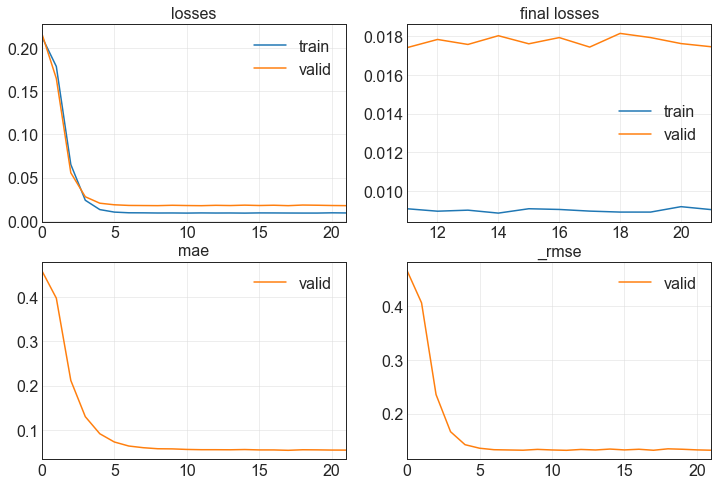

49.46108150482178                                                                                                      
[0.00902312807738781, 0.01746681146323681, 0.054695554077625275, 0.13216207921504974]                                  
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': False, 'epochs': 50, 'hidden_size': 100, 'lr': 0.001, 'n_layers': 1, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 5}
LSTM                                                                                                                   
 19%|███████▉                                  | 19/100 [27:38<2:47:38, 124.18s/trial, best loss: 0.003829583991318941]

No improvement since epoch 8: early stopping                                                                           
 19%|███████▉                                  | 19/100 [27:44<2:47:38, 124.18s/trial, best loss: 0.003829583991318941]

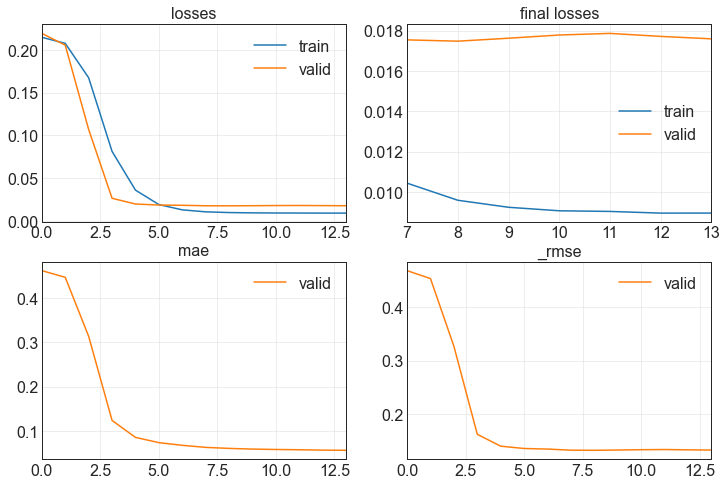

6.54214072227478                                                                                                       
[0.008946807123720646, 0.01759311556816101, 0.05635775998234749, 0.13263903558254242]                                  
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 20, 'hidden_size': 50, 'lr': 0.01, 'n_layers': 2, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 5}
LSTM                                                                                                                   
 20%|████████▌                                  | 20/100 [27:46<1:59:04, 89.31s/trial, best loss: 0.003829583991318941]

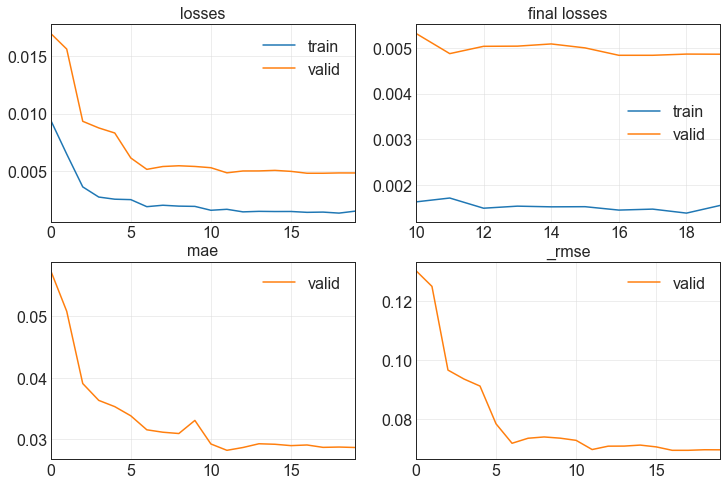

84.2468626499176                                                                                                       
[0.0015532165998592973, 0.004862871952354908, 0.028699437156319618, 0.06973428279161453]                               
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 20, 'hidden_size': 50, 'lr': 0.01, 'n_layers': 2, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 5}
LSTM                                                                                                                   
 21%|█████████                                  | 21/100 [29:11<1:56:08, 88.21s/trial, best loss: 0.003829583991318941]

No improvement since epoch 11: early stopping                                                                          
 21%|█████████                                  | 21/100 [30:21<1:56:08, 88.21s/trial, best loss: 0.003829583991318941]

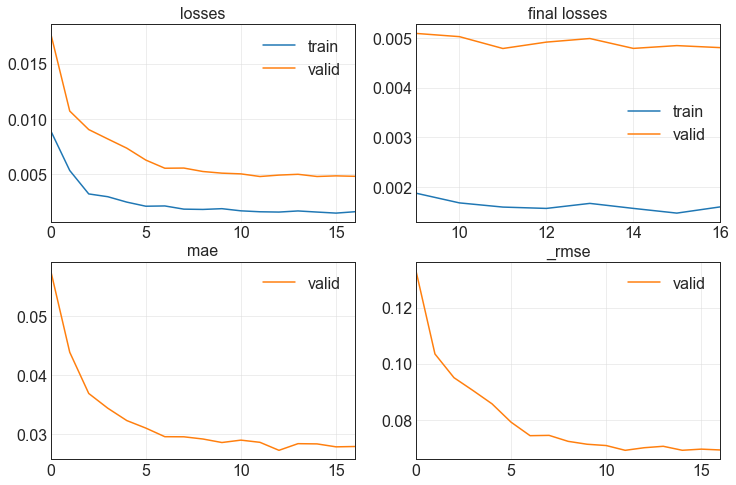

70.34094572067261                                                                                                      
[0.001604081247933209, 0.004804336000233889, 0.027903301641345024, 0.06931331753730774]                                
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 20, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 4, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 5}
LSTM                                                                                                                   
 22%|█████████▍                                 | 22/100 [30:23<1:48:16, 83.28s/trial, best loss: 0.003829583991318941]

No improvement since epoch 10: early stopping                                                                          
 22%|█████████▍                                 | 22/100 [32:22<1:48:16, 83.28s/trial, best loss: 0.003829583991318941]

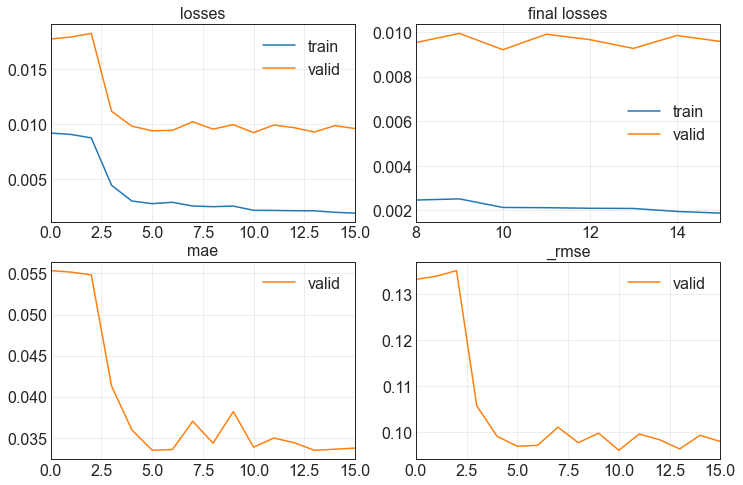

118.97047805786133                                                                                                     
[0.0018808156019076705, 0.009580573067069054, 0.03374611213803291, 0.09788040816783905]                                
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 50, 'hidden_size': 50, 'lr': 0.01, 'n_layers': 2, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 5}
LSTM                                                                                                                   
 23%|█████████▉                                 | 23/100 [32:24<2:01:12, 94.45s/trial, best loss: 0.003829583991318941]

No improvement since epoch 21: early stopping                                                                          
 23%|█████████▉                                 | 23/100 [34:20<2:01:12, 94.45s/trial, best loss: 0.003829583991318941]

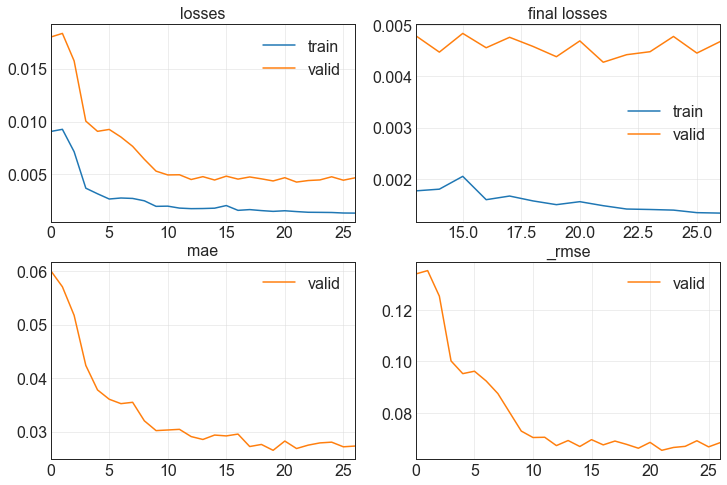

116.70091390609741                                                                                                     
[0.0013347790809348226, 0.0046743243001401424, 0.027324404567480087, 0.06836903095245361]                              
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 20, 'hidden_size': 50, 'lr': 0.01, 'n_layers': 2, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 5}
LSTM                                                                                                                   
 24%|██████████                                | 24/100 [34:22<2:08:39, 101.58s/trial, best loss: 0.003829583991318941]

No improvement since epoch 13: early stopping                                                                          
 24%|██████████                                | 24/100 [35:46<2:08:39, 101.58s/trial, best loss: 0.003829583991318941]

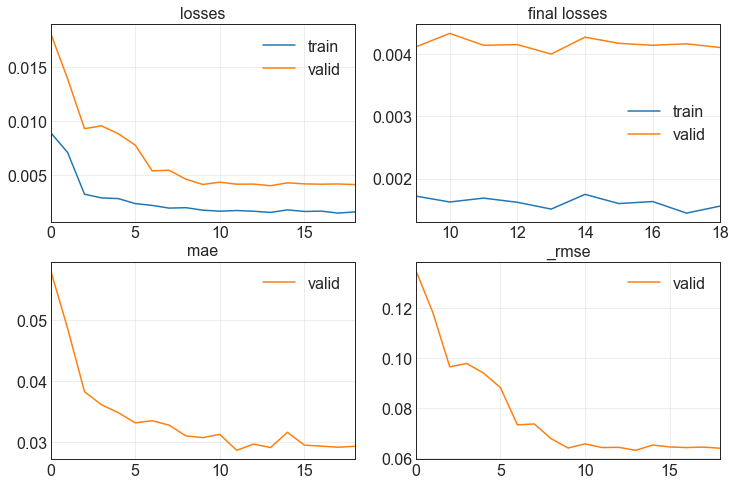

84.1029851436615                                                                                                       
[0.0015614372678101063, 0.0041015129536390305, 0.029270702973008156, 0.06404305249452591]                              
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': True, 'epochs': 20, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 2, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 5}
LSTM                                                                                                                   
 25%|██████████▊                                | 25/100 [35:48<2:01:00, 96.81s/trial, best loss: 0.003829583991318941]

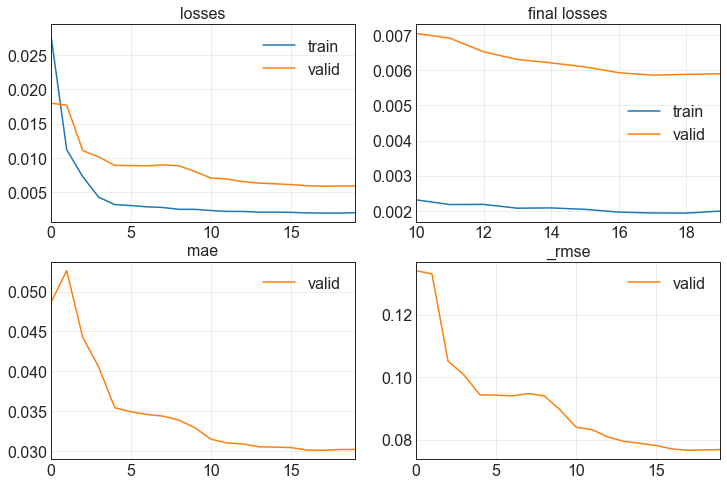

29.422924280166626                                                                                                     
[0.0019928528927266598, 0.005902649834752083, 0.030168769881129265, 0.07682870328426361]                               
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 20, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 4, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 5}
LSTM                                                                                                                   
 26%|███████████▏                               | 26/100 [36:19<1:35:00, 77.04s/trial, best loss: 0.003829583991318941]

No improvement since epoch 4: early stopping                                                                           
 26%|███████████▏                               | 26/100 [37:23<1:35:00, 77.04s/trial, best loss: 0.003829583991318941]

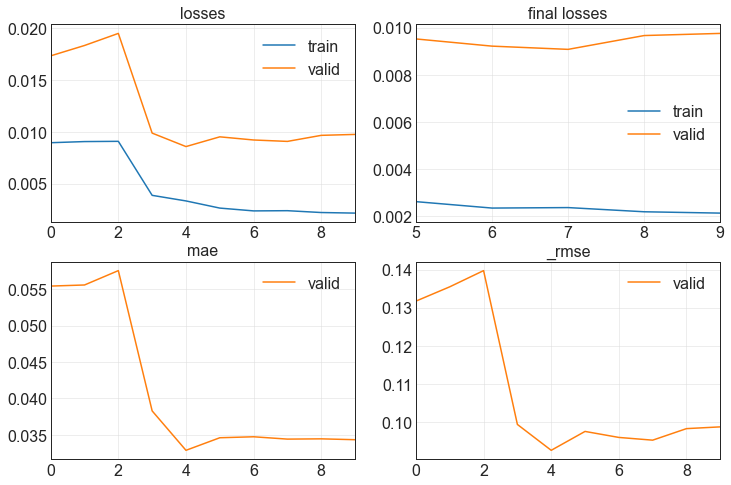

64.99516105651855                                                                                                      
[0.0021432724315673113, 0.0097533343359828, 0.03435160219669342, 0.09875897318124771]                                  
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 20, 'hidden_size': 50, 'lr': 0.01, 'n_layers': 2, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 5}
LSTM                                                                                                                   
 27%|███████████▌                               | 27/100 [37:25<1:29:54, 73.90s/trial, best loss: 0.003829583991318941]

No improvement since epoch 8: early stopping                                                                           
 27%|███████████▌                               | 27/100 [38:22<1:29:54, 73.90s/trial, best loss: 0.003829583991318941]

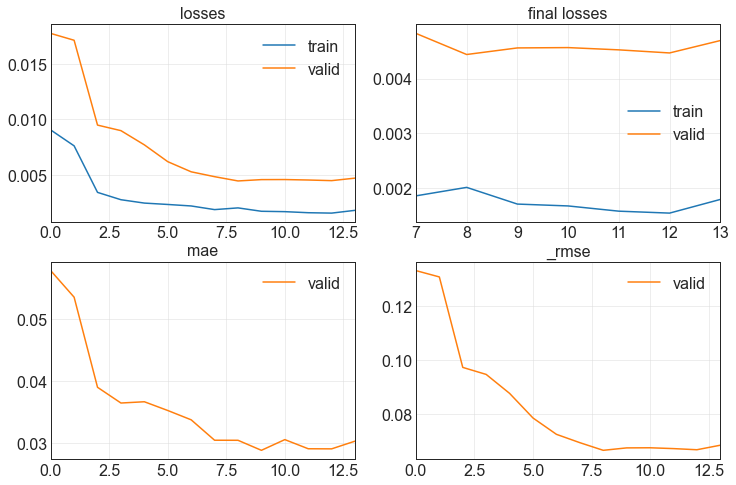

57.42041301727295                                                                                                      
[0.0017856471240520477, 0.004695546347647905, 0.030327683314681053, 0.06852405518293381]                               
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 20, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 4, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 5}
LSTM                                                                                                                   
 28%|████████████                               | 28/100 [38:24<1:23:14, 69.37s/trial, best loss: 0.003829583991318941]

No improvement since epoch 8: early stopping                                                                           
 28%|████████████                               | 28/100 [40:05<1:23:14, 69.37s/trial, best loss: 0.003829583991318941]

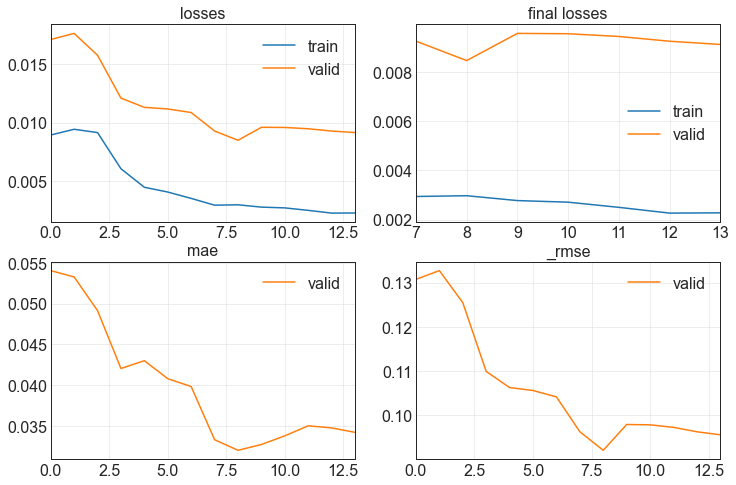

101.21914839744568                                                                                                     
[0.0022721271961927414, 0.009143478237092495, 0.03422302380204201, 0.09562154114246368]                                
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': True, 'epochs': 20, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 2, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 5}
LSTM                                                                                                                   
 29%|████████████▍                              | 29/100 [40:07<1:33:53, 79.35s/trial, best loss: 0.003829583991318941]

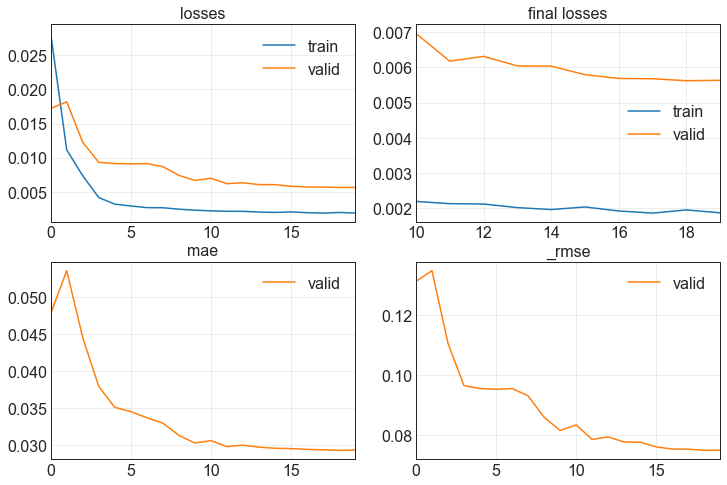

26.768160581588745                                                                                                     
[0.0018711895681917667, 0.005635658744722605, 0.02937738224864006, 0.07507102191448212]                                
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 20, 'hidden_size': 50, 'lr': 0.01, 'n_layers': 3, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 5}
LSTM                                                                                                                   
 30%|████████████▉                              | 30/100 [40:35<1:14:40, 64.01s/trial, best loss: 0.003829583991318941]

No improvement since epoch 14: early stopping                                                                          
 30%|████████████▉                              | 30/100 [42:16<1:14:40, 64.01s/trial, best loss: 0.003829583991318941]

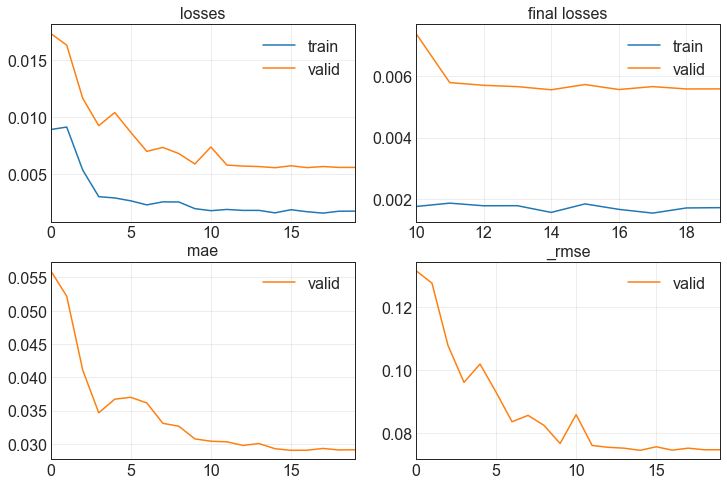

101.5924756526947                                                                                                      
[0.0017348651308566332, 0.0055786604061722755, 0.02912316471338272, 0.07469042390584946]                               
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'epochs': 20, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 2, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 5}
LSTM                                                                                                                   
 31%|█████████████▎                             | 31/100 [42:18<1:27:03, 75.70s/trial, best loss: 0.003829583991318941]

No improvement since epoch 14: early stopping                                                                          
 31%|█████████████▎                             | 31/100 [42:58<1:27:03, 75.70s/trial, best loss: 0.003829583991318941]

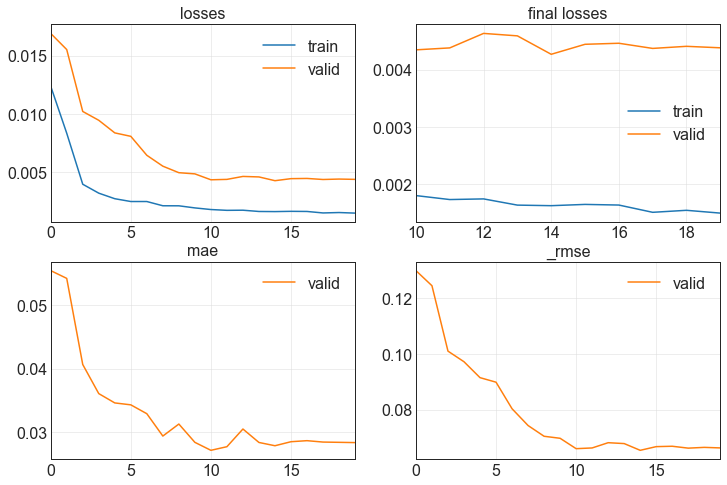

40.366114139556885                                                                                                     
[0.0014882811810821295, 0.0043831211514770985, 0.028417576104402542, 0.06620514392852783]                              
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': True, 'epochs': 20, 'hidden_size': 50, 'lr': 0.01, 'n_layers': 3, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 5}
LSTM                                                                                                                   
 32%|█████████████▊                             | 32/100 [42:59<1:14:15, 65.52s/trial, best loss: 0.003829583991318941]

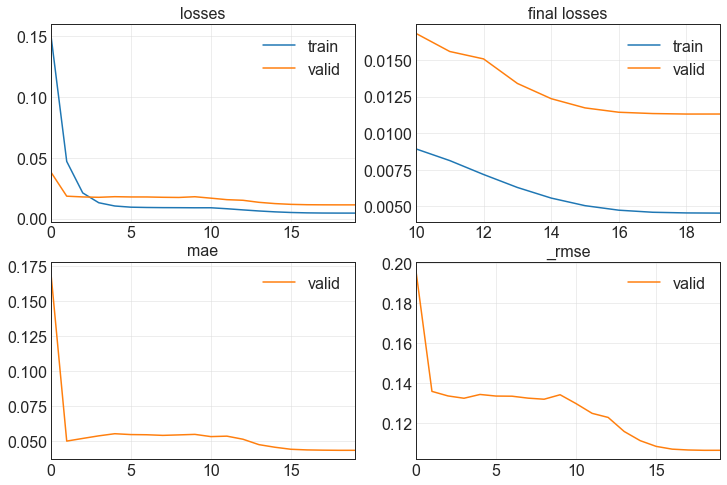

14.899750709533691                                                                                                     
[0.004536292050033808, 0.011304423213005066, 0.043559376150369644, 0.1063222587108612]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 20, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 4, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 5}
LSTM                                                                                                                   
 33%|██████████████▊                              | 33/100 [43:16<56:40, 50.76s/trial, best loss: 0.003829583991318941]

No improvement since epoch 9: early stopping                                                                           
 33%|██████████████▊                              | 33/100 [45:04<56:40, 50.76s/trial, best loss: 0.003829583991318941]

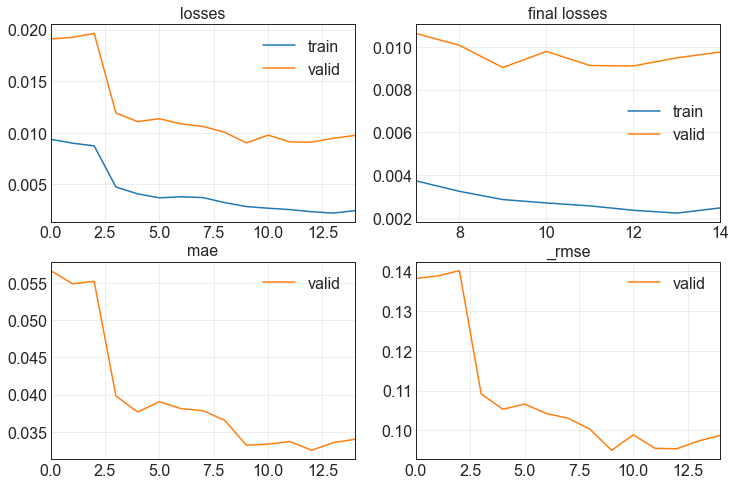

108.28666543960571                                                                                                     
[0.00246908119879663, 0.00975401047617197, 0.033987149596214294, 0.0987624004483223]                                   
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 20, 'hidden_size': 200, 'lr': 0.0001, 'n_layers': 2, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 5}
LSTM                                                                                                                   
 34%|██████████████▌                            | 34/100 [45:06<1:15:17, 68.45s/trial, best loss: 0.003829583991318941]

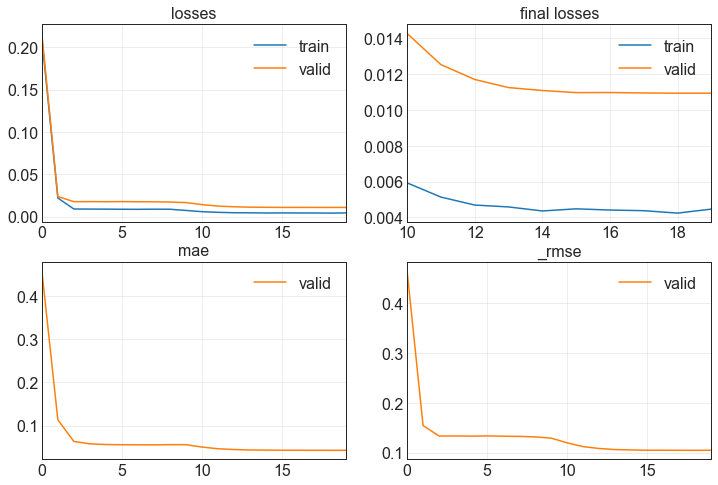

92.42384839057922                                                                                                      
[0.004462976474314928, 0.010938197374343872, 0.04280731827020645, 0.10458583384752274]                                 
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'epochs': 100, 'hidden_size': 50, 'lr': 0.01, 'n_layers': 5, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 5}
LSTM                                                                                                                   
 35%|███████████████                            | 35/100 [46:39<1:22:25, 76.08s/trial, best loss: 0.003829583991318941]

No improvement since epoch 0: early stopping                                                                           
 35%|███████████████                            | 35/100 [46:59<1:22:25, 76.08s/trial, best loss: 0.003829583991318941]

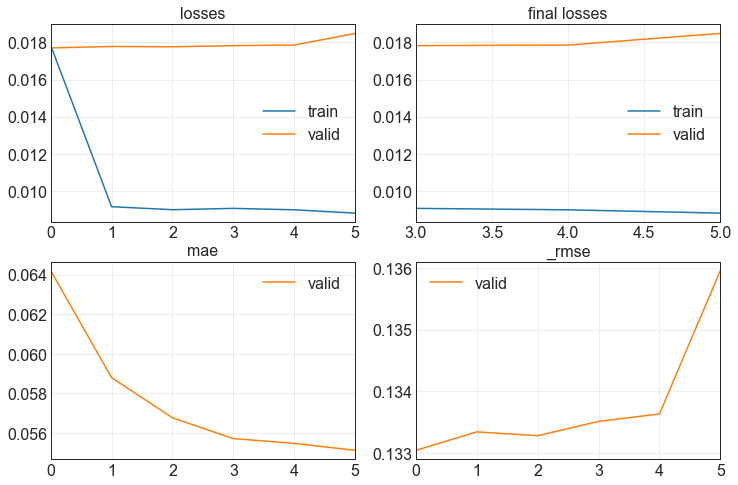

20.38839864730835                                                                                                      
[0.008812518790364265, 0.018483690917491913, 0.05513177812099457, 0.13595473766326904]                                 
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': True, 'epochs': 20, 'hidden_size': 100, 'lr': 0.0001, 'n_layers': 2, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 5}
LSTM                                                                                                                   
 36%|███████████████▍                           | 36/100 [47:01<1:03:47, 59.80s/trial, best loss: 0.003829583991318941]

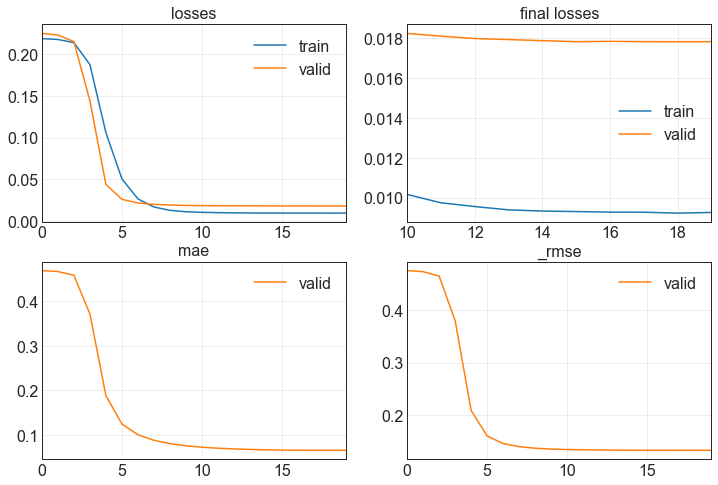

14.347742795944214                                                                                                     
[0.009253107942640781, 0.017832765355706215, 0.06532000750303268, 0.1335393637418747]                                  
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': False, 'epochs': 20, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 3, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 5}
LSTM                                                                                                                   
 37%|████████████████▋                            | 37/100 [47:17<48:55, 46.59s/trial, best loss: 0.003829583991318941]

No improvement since epoch 6: early stopping                                                                           
 37%|████████████████▋                            | 37/100 [47:31<48:55, 46.59s/trial, best loss: 0.003829583991318941]

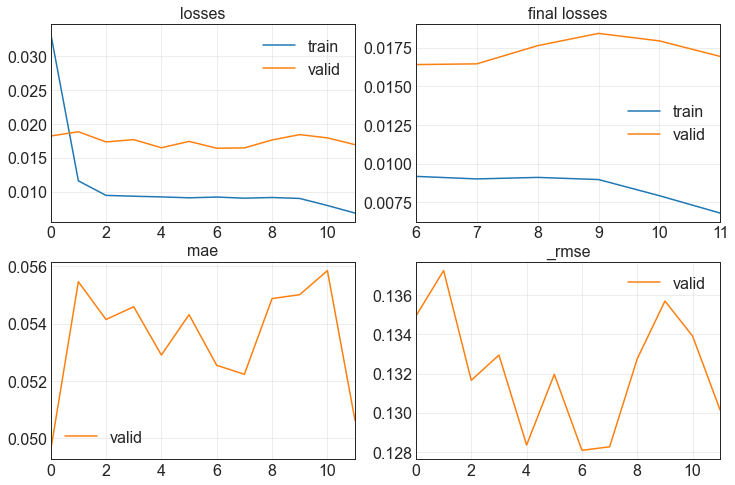

14.193657636642456                                                                                                     
[0.006809506565332413, 0.01692861318588257, 0.050615210086107254, 0.1301100105047226]                                  
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 100, 'hidden_size': 50, 'lr': 0.01, 'n_layers': 2, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 5}
LSTM                                                                                                                   
 38%|█████████████████                            | 38/100 [47:33<38:32, 37.30s/trial, best loss: 0.003829583991318941]

No improvement since epoch 17: early stopping                                                                          
 38%|█████████████████                            | 38/100 [49:07<38:32, 37.30s/trial, best loss: 0.003829583991318941]

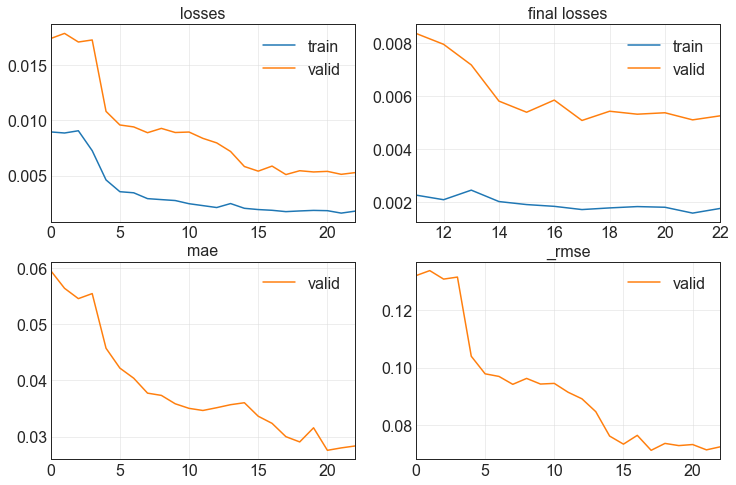

94.49593234062195                                                                                                      
[0.0017737298039719462, 0.005261120852082968, 0.028324000537395477, 0.07253356277942657]                               
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': True, 'epochs': 20, 'hidden_size': 200, 'lr': 0.0001, 'n_layers': 5, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 5}
LSTM                                                                                                                   
 39%|█████████████████▌                           | 39/100 [49:09<55:47, 54.88s/trial, best loss: 0.003829583991318941]

No improvement since epoch 14: early stopping                                                                          
 39%|█████████████████▌                           | 39/100 [49:34<55:47, 54.88s/trial, best loss: 0.003829583991318941]

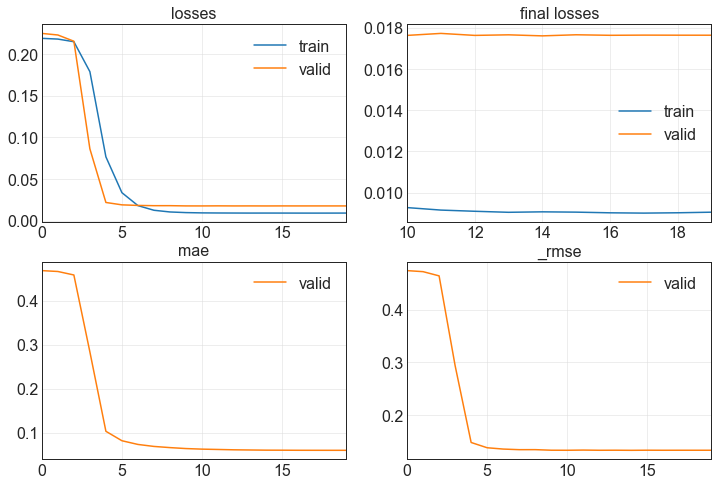

26.04530119895935                                                                                                      
[0.009047742001712322, 0.017631294205784798, 0.05958607792854309, 0.13278287649154663]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 100, 'hidden_size': 50, 'lr': 0.01, 'n_layers': 2, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 10}
LSTM                                                                                                                   
 40%|██████████████████                           | 40/100 [49:36<46:40, 46.68s/trial, best loss: 0.003829583991318941]

No improvement since epoch 33: early stopping                                                                          
 40%|██████████████████                           | 40/100 [52:36<46:40, 46.68s/trial, best loss: 0.003829583991318941]

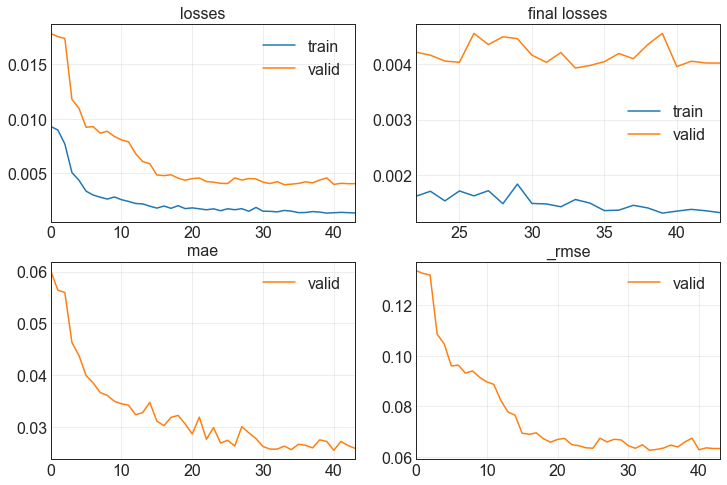

180.1478190422058                                                                                                      
[0.0013215310173109174, 0.004020569380372763, 0.025918960571289062, 0.06340796500444412]                               
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': False, 'epochs': 100, 'hidden_size': 100, 'lr': 0.001, 'n_layers': 4, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 10}
LSTM                                                                                                                   
 41%|█████████████████▋                         | 41/100 [52:38<1:25:41, 87.14s/trial, best loss: 0.003829583991318941]

No improvement since epoch 15: early stopping                                                                          
 41%|█████████████████▋                         | 41/100 [53:29<1:25:41, 87.14s/trial, best loss: 0.003829583991318941]

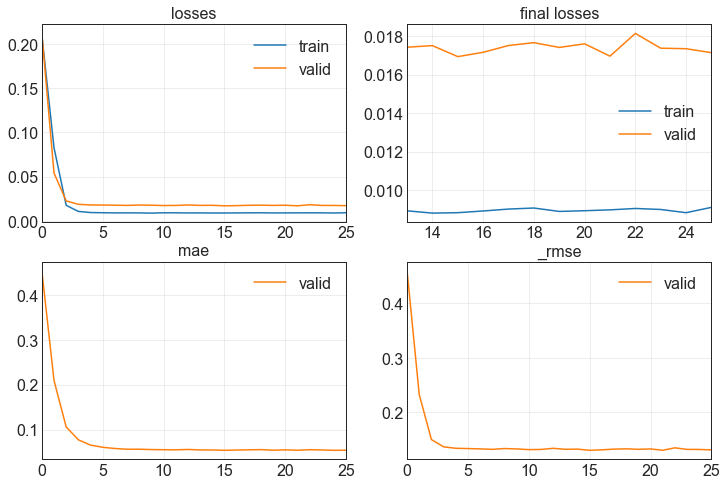

51.33653688430786                                                                                                      
[0.009099334478378296, 0.017144810408353806, 0.05377542972564697, 0.13093820214271545]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 100, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 2, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 10}
LSTM                                                                                                                   
 42%|██████████████████                         | 42/100 [53:30<1:14:16, 76.84s/trial, best loss: 0.003829583991318941]

No improvement since epoch 35: early stopping                                                                          
 42%|██████████████████                         | 42/100 [57:02<1:14:16, 76.84s/trial, best loss: 0.003829583991318941]

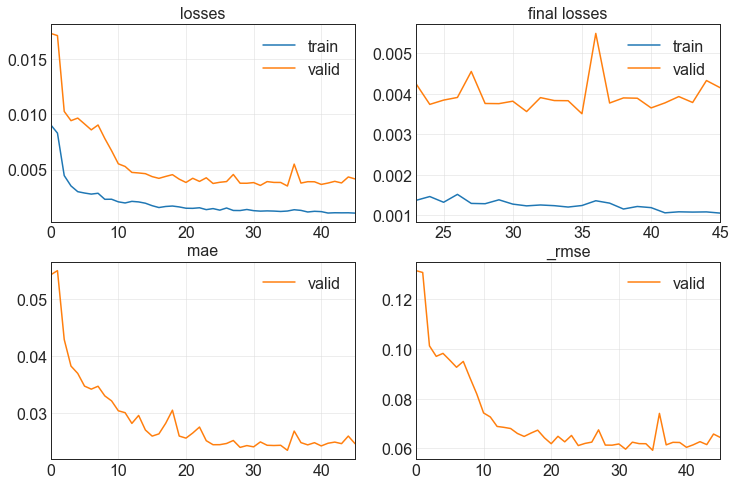

211.7006185054779                                                                                                      
[0.0010530240833759308, 0.00414718734100461, 0.024646196514368057, 0.06439866870641708]                                
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': False, 'epochs': 100, 'hidden_size': 50, 'lr': 0.0001, 'n_layers': 3, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 10}
LSTM                                                                                                                   
 43%|██████████████████                        | 43/100 [57:04<1:51:50, 117.72s/trial, best loss: 0.003829583991318941]

No improvement since epoch 37: early stopping                                                                          
 43%|██████████████████                        | 43/100 [57:49<1:51:50, 117.72s/trial, best loss: 0.003829583991318941]

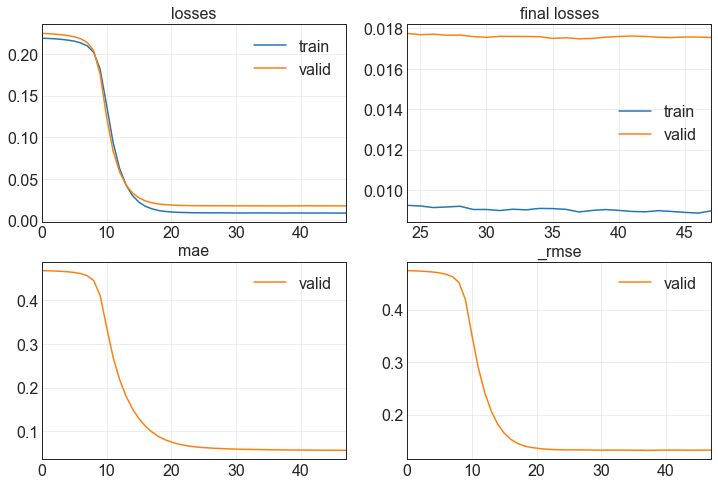

45.923903465270996                                                                                                     
[0.00896154809743166, 0.017552806064486504, 0.05640123039484024, 0.1324869990348816]                                   
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 100, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 1, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 10}
LSTM                                                                                                                   
 44%|██████████████████▉                        | 44/100 [57:51<1:30:10, 96.62s/trial, best loss: 0.003829583991318941]

No improvement since epoch 65: early stopping                                                                          
 44%|██████████████████                       | 44/100 [1:01:58<1:30:10, 96.62s/trial, best loss: 0.003829583991318941]

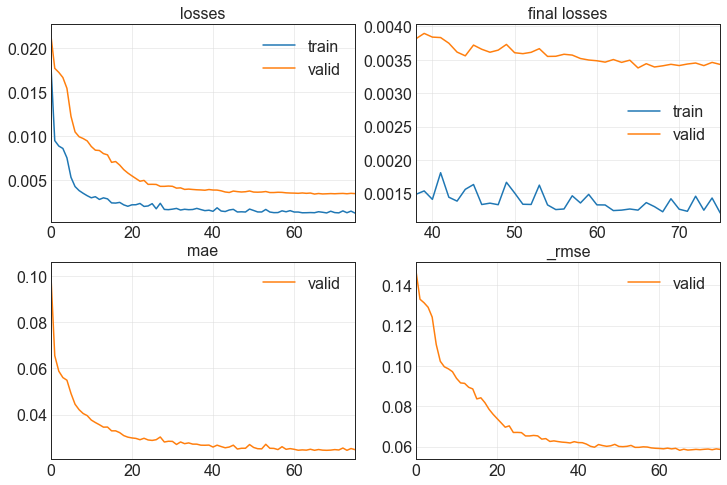

247.523334980011                                                                                                       
[0.0012055898550897837, 0.0034295537043362856, 0.024842994287610054, 0.05856239050626755]                              
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': True, 'epochs': 100, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 1, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 10}
LSTM                                                                                                                   
 45%|█████████████████▌                     | 45/100 [1:02:00<2:10:27, 142.31s/trial, best loss: 0.0034295537043362856]

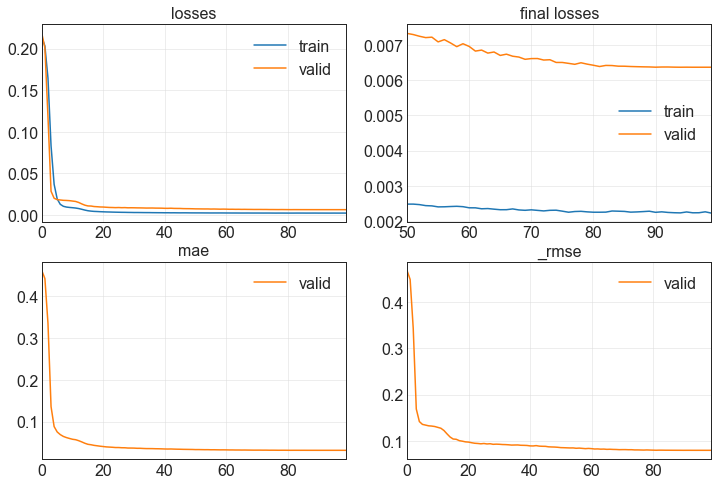

53.6424617767334                                                                                                       
[0.002222600160166621, 0.006369489245116711, 0.031312089413404465, 0.07980908453464508]                                
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': False, 'epochs': 100, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 1, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 10}
LSTM                                                                                                                   
 46%|█████████████████▉                     | 46/100 [1:02:55<1:44:32, 116.15s/trial, best loss: 0.0034295537043362856]

No improvement since epoch 40: early stopping                                                                          
 46%|█████████████████▉                     | 46/100 [1:05:06<1:44:32, 116.15s/trial, best loss: 0.0034295537043362856]

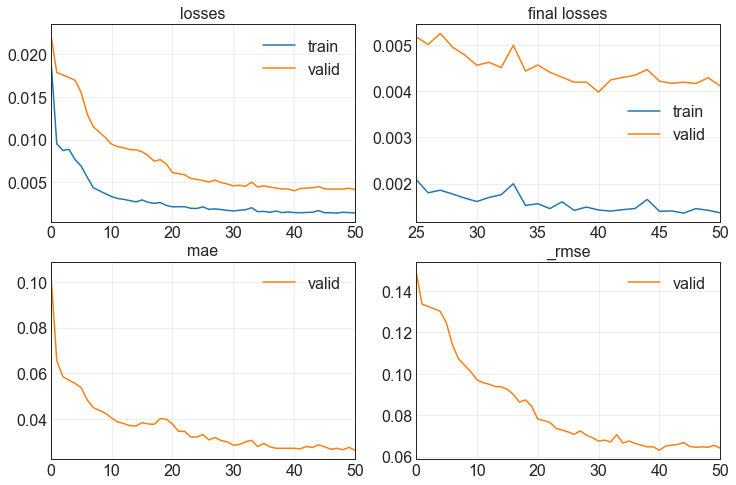

131.26833963394165                                                                                                     
[0.0013681561686098576, 0.004110336769372225, 0.02629874087870121, 0.06411189585924149]                                
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'epochs': 100, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 1, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 10}
LSTM                                                                                                                   
 47%|██████████████████▎                    | 47/100 [1:05:08<1:46:58, 121.11s/trial, best loss: 0.0034295537043362856]

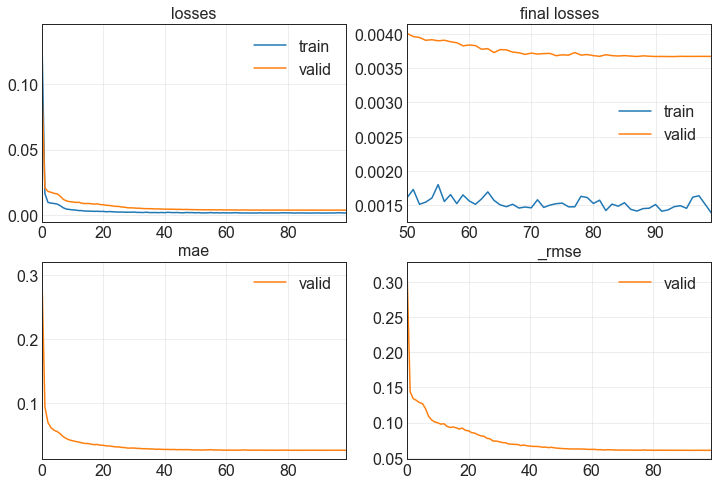

173.03143072128296                                                                                                     
[0.0013857318554073572, 0.003672007005661726, 0.026822594925761223, 0.06059708073735237]                               
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'epochs': 100, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 1, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 10}
LSTM                                                                                                                   
 48%|██████████████████▋                    | 48/100 [1:08:02<1:58:50, 137.12s/trial, best loss: 0.0034295537043362856]

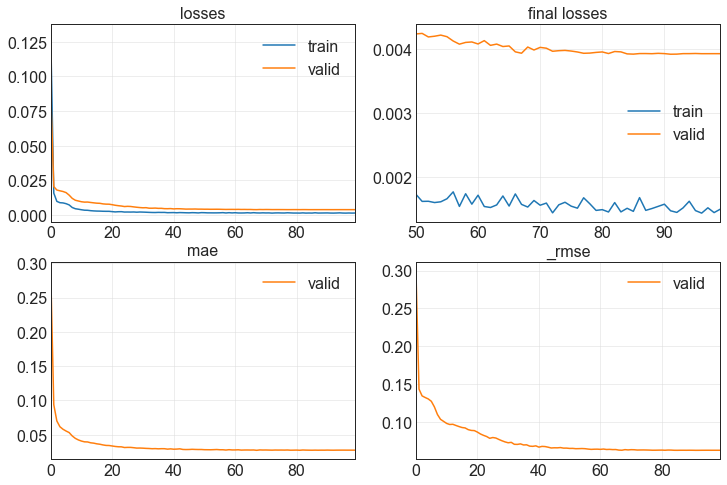

173.5900707244873                                                                                                      
[0.0014925424475222826, 0.003928440157324076, 0.02767847664654255, 0.06267726421356201]                                
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'epochs': 100, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 1, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 10}
LSTM                                                                                                                   
 49%|███████████████████                    | 49/100 [1:10:57<2:06:13, 148.49s/trial, best loss: 0.0034295537043362856]

No improvement since epoch 88: early stopping                                                                          
 49%|███████████████████                    | 49/100 [1:13:49<2:06:13, 148.49s/trial, best loss: 0.0034295537043362856]

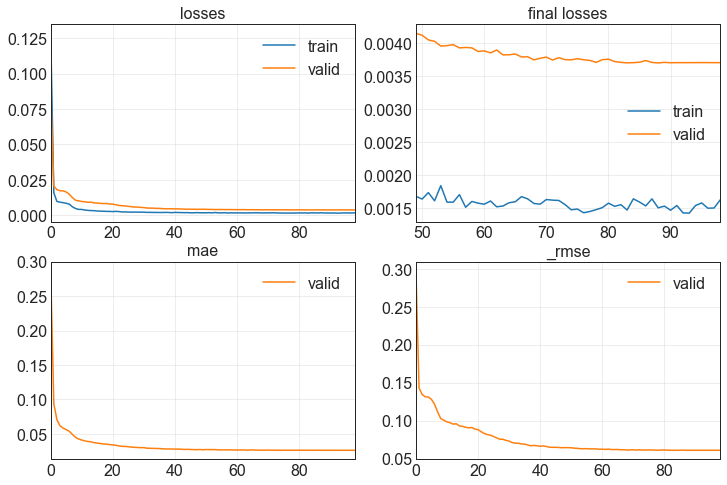

172.24712657928467                                                                                                     
[0.001630681217648089, 0.003702663816511631, 0.026152901351451874, 0.060849517583847046]                               
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': False, 'epochs': 100, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 1, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 10}
LSTM                                                                                                                   
 50%|███████████████████▌                   | 50/100 [1:13:51<2:10:02, 156.05s/trial, best loss: 0.0034295537043362856]

No improvement since epoch 67: early stopping                                                                          
 50%|███████████████████▌                   | 50/100 [1:15:37<2:10:02, 156.05s/trial, best loss: 0.0034295537043362856]

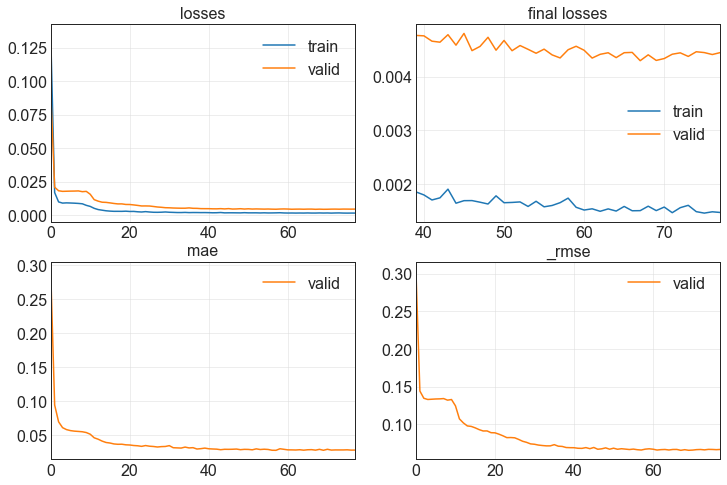

106.75071001052856                                                                                                     
[0.0014652308309450746, 0.00444706529378891, 0.028466690331697464, 0.06668631732463837]                                
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'epochs': 100, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 1, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 10}
LSTM                                                                                                                   
 51%|███████████████████▉                   | 51/100 [1:15:39<1:55:43, 141.69s/trial, best loss: 0.0034295537043362856]

No improvement since epoch 71: early stopping                                                                          
 51%|███████████████████▉                   | 51/100 [1:18:01<1:55:43, 141.69s/trial, best loss: 0.0034295537043362856]

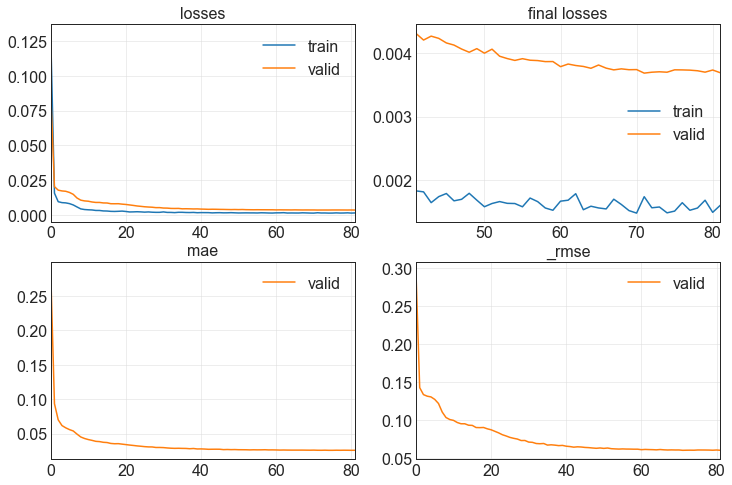

142.5795602798462                                                                                                      
[0.0016081581125035882, 0.003689591307193041, 0.025972237810492516, 0.06074200198054314]                               
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'epochs': 100, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 1, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 10}
LSTM                                                                                                                   
 52%|████████████████████▎                  | 52/100 [1:18:03<1:53:54, 142.40s/trial, best loss: 0.0034295537043362856]

No improvement since epoch 82: early stopping                                                                          
 52%|████████████████████▎                  | 52/100 [1:20:41<1:53:54, 142.40s/trial, best loss: 0.0034295537043362856]

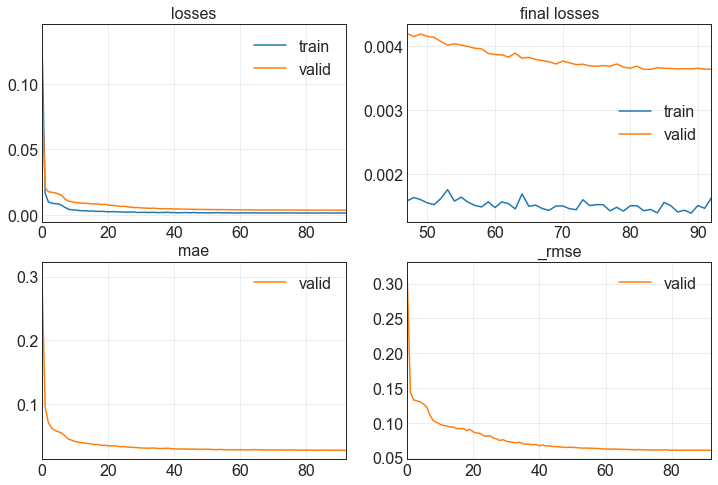

158.47683835029602                                                                                                     
[0.0016319736605510116, 0.003645621705800295, 0.026839854195713997, 0.06037898361682892]                               
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': False, 'epochs': 100, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 1, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 10}
LSTM                                                                                                                   
 53%|████████████████████▋                  | 53/100 [1:20:43<1:55:39, 147.65s/trial, best loss: 0.0034295537043362856]

No improvement since epoch 75: early stopping                                                                          
 53%|████████████████████▋                  | 53/100 [1:22:36<1:55:39, 147.65s/trial, best loss: 0.0034295537043362856]

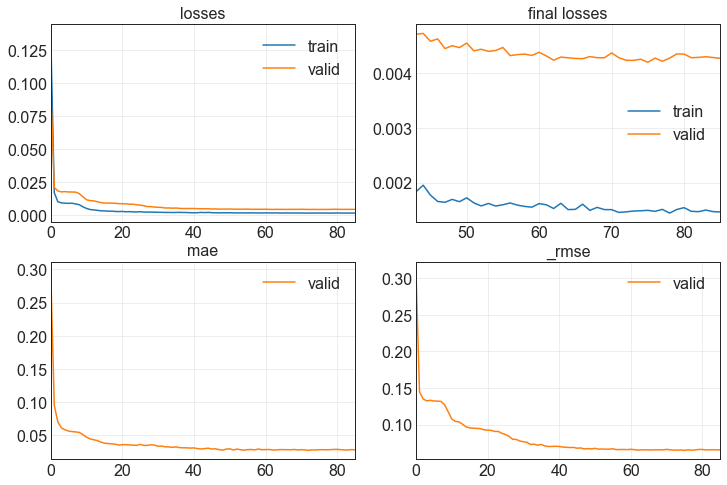

113.48975205421448                                                                                                     
[0.0014624432660639286, 0.00427145604044199, 0.02823793515563011, 0.06535637378692627]                                 
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'epochs': 100, 'hidden_size': 100, 'lr': 0.001, 'n_layers': 1, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 10}
LSTM                                                                                                                   
 54%|█████████████████████                  | 54/100 [1:22:38<1:45:39, 137.82s/trial, best loss: 0.0034295537043362856]

No improvement since epoch 60: early stopping                                                                          
 54%|█████████████████████                  | 54/100 [1:24:23<1:45:39, 137.82s/trial, best loss: 0.0034295537043362856]

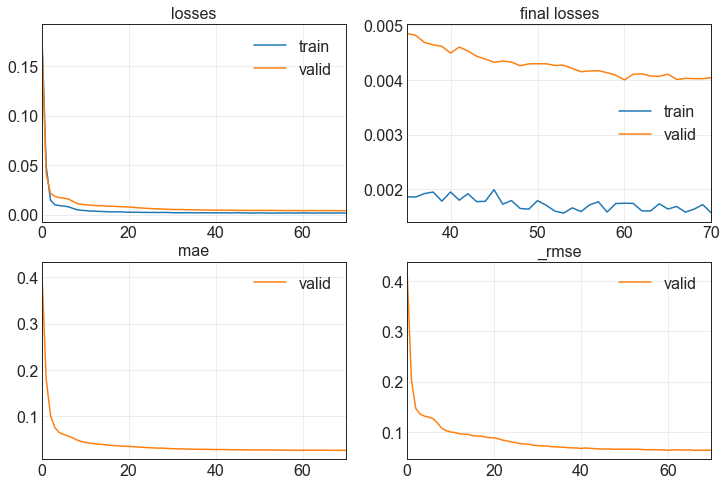

105.31433391571045                                                                                                     
[0.0015636186581104994, 0.004040205851197243, 0.026358598843216896, 0.06356261670589447]                               
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': True, 'epochs': 50, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 1, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 10}
LSTM                                                                                                                   
 55%|█████████████████████▍                 | 55/100 [1:24:24<1:36:22, 128.49s/trial, best loss: 0.0034295537043362856]

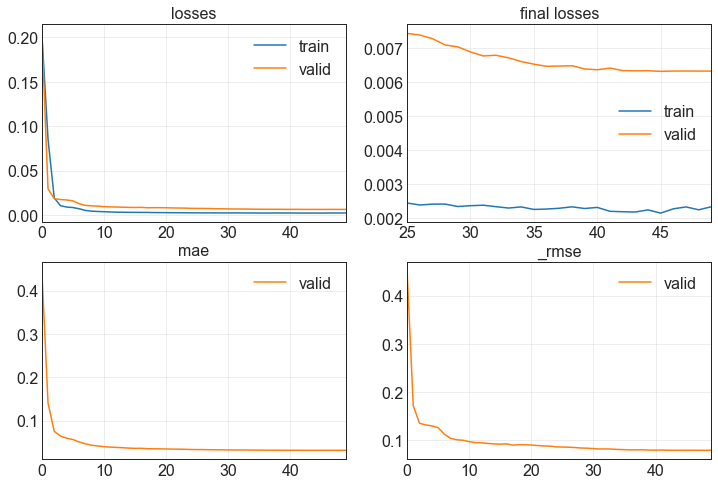

47.84289002418518                                                                                                      
[0.002334623597562313, 0.006317673716694117, 0.03177224099636078, 0.07948378473520279]                                 
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'epochs': 100, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 1, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 10}
LSTM                                                                                                                   
 56%|█████████████████████▊                 | 56/100 [1:25:14<1:16:47, 104.71s/trial, best loss: 0.0034295537043362856]

No improvement since epoch 76: early stopping                                                                          
 56%|█████████████████████▊                 | 56/100 [1:27:39<1:16:47, 104.71s/trial, best loss: 0.0034295537043362856]

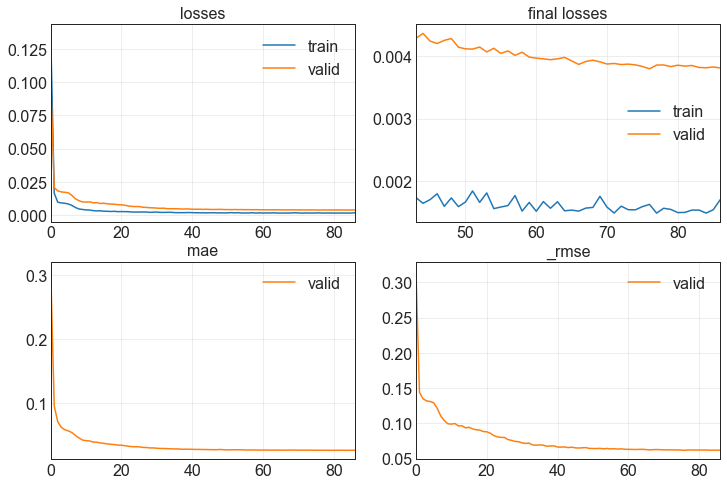

145.92551732063293                                                                                                     
[0.001698729582130909, 0.0038148199673742056, 0.02614007331430912, 0.06176422908902168]                                
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': False, 'epochs': 50, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 5, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 10}
LSTM                                                                                                                   
 57%|██████████████████████▏                | 57/100 [1:27:41<1:24:12, 117.49s/trial, best loss: 0.0034295537043362856]

No improvement since epoch 18: early stopping                                                                          
 57%|██████████████████████▏                | 57/100 [1:28:04<1:24:12, 117.49s/trial, best loss: 0.0034295537043362856]

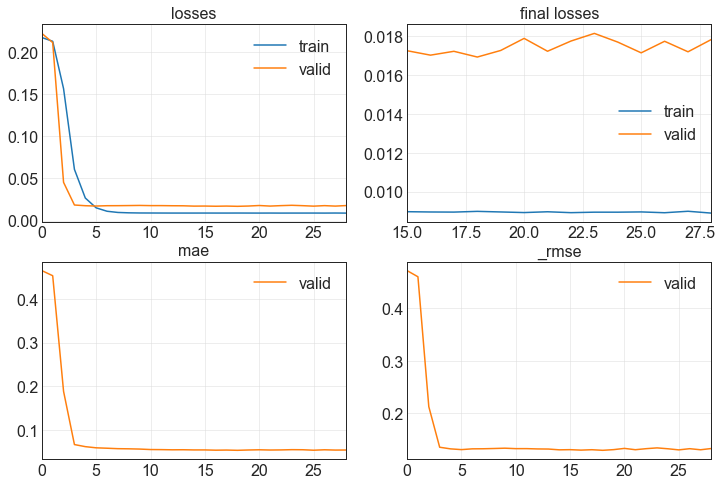

23.739304304122925                                                                                                     
[0.00889667496085167, 0.0178352203220129, 0.05423720180988312, 0.1335485726594925]                                     
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'epochs': 100, 'hidden_size': 100, 'lr': 0.001, 'n_layers': 1, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 10}
LSTM                                                                                                                   
 58%|███████████████████████▏                | 58/100 [1:28:06<1:02:51, 89.79s/trial, best loss: 0.0034295537043362856]

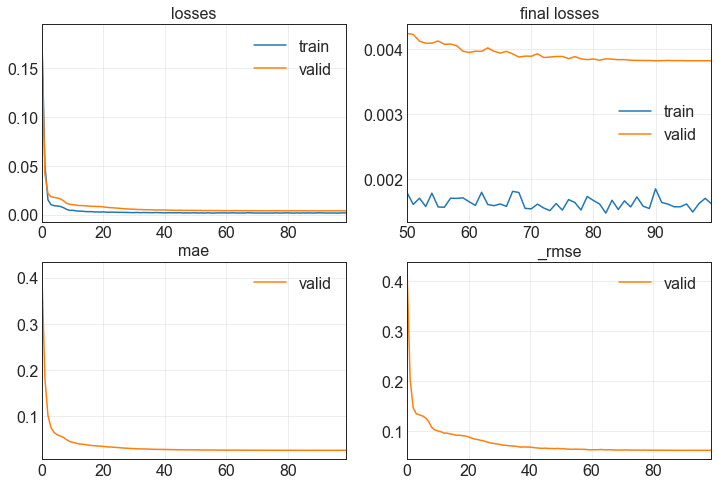

148.18942761421204                                                                                                     
[0.0016249309992417693, 0.0038224479649215937, 0.02625254914164543, 0.0618259496986866]                                
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': True, 'epochs': 100, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 1, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 10}
LSTM                                                                                                                   
 59%|███████████████████████                | 59/100 [1:30:36<1:13:36, 107.73s/trial, best loss: 0.0034295537043362856]

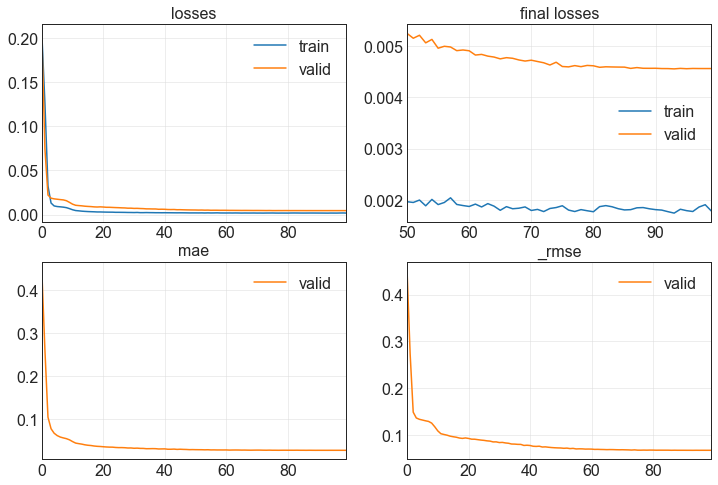

95.86513590812683                                                                                                      
[0.0017795846797525883, 0.004563614726066589, 0.028362516313791275, 0.0675545334815979]                                
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'epochs': 50, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 4, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 10}
LSTM                                                                                                                   
 60%|███████████████████████▍               | 60/100 [1:32:13<1:09:43, 104.58s/trial, best loss: 0.0034295537043362856]

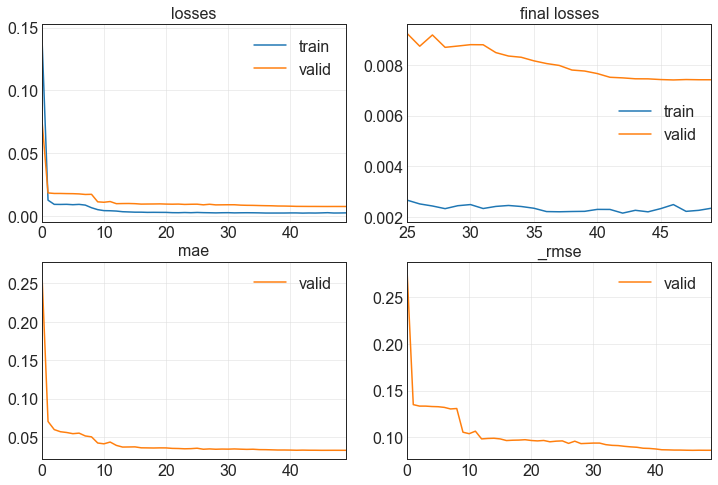

189.4282591342926                                                                                                      
[0.0023361551575362682, 0.007414378225803375, 0.03276299685239792, 0.0861067846417427]                                 
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': False, 'epochs': 100, 'hidden_size': 100, 'lr': 0.0001, 'n_layers': 5, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 10}
LSTM                                                                                                                   
 61%|███████████████████████▊               | 61/100 [1:35:24<1:24:47, 130.45s/trial, best loss: 0.0034295537043362856]

No improvement since epoch 51: early stopping                                                                          
 61%|███████████████████████▊               | 61/100 [1:36:11<1:24:47, 130.45s/trial, best loss: 0.0034295537043362856]

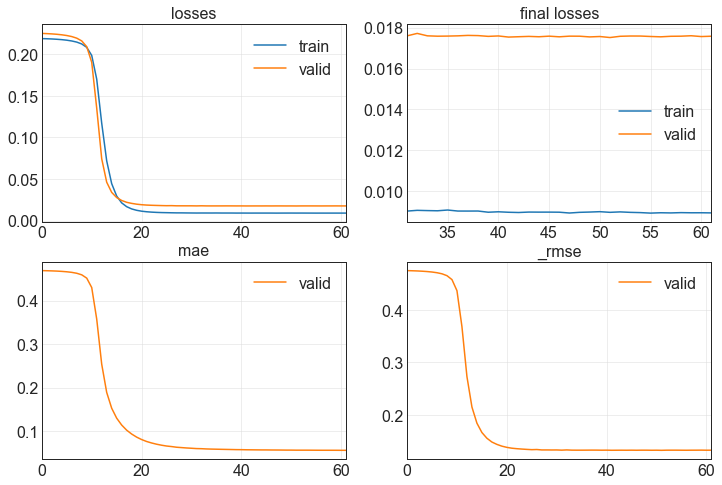

47.76966428756714                                                                                                      
[0.00893398281186819, 0.017581380903720856, 0.05611736327409744, 0.13259480893611908]                                  
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': True, 'epochs': 100, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 3, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 10}
LSTM                                                                                                                   
 62%|████████████████████████▏              | 62/100 [1:36:13<1:07:10, 106.07s/trial, best loss: 0.0034295537043362856]

No improvement since epoch 70: early stopping                                                                          
 62%|████████████████████████▏              | 62/100 [1:38:26<1:07:10, 106.07s/trial, best loss: 0.0034295537043362856]

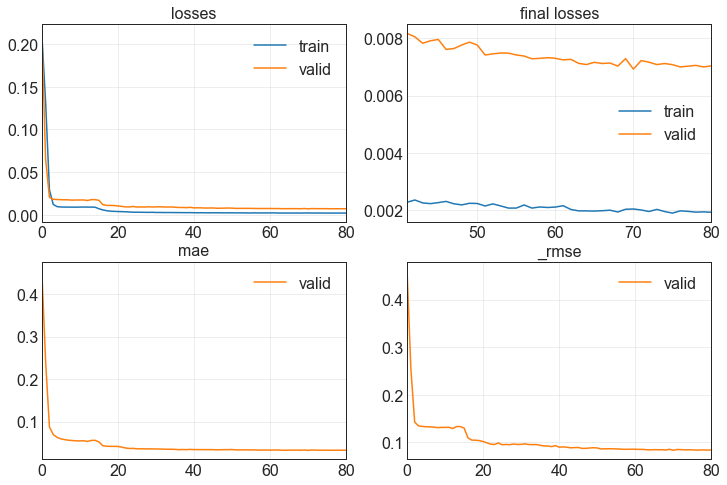

133.86980676651                                                                                                        
[0.0019329105271026492, 0.00703339371830225, 0.032742977142333984, 0.08386532217264175]                                
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'epochs': 50, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 1, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 10}
LSTM                                                                                                                   
 63%|████████████████████████▌              | 63/100 [1:38:28<1:10:48, 114.82s/trial, best loss: 0.0034295537043362856]

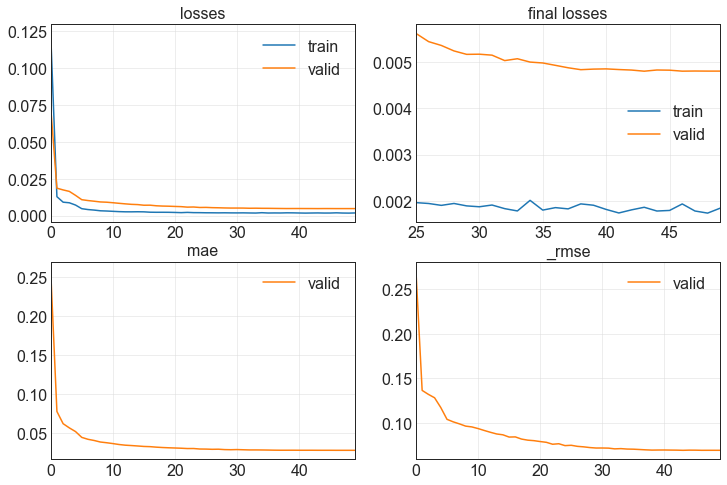

84.56139540672302                                                                                                      
[0.0018448318587616086, 0.0047991531901061535, 0.02834036946296692, 0.06927591562271118]                               
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 100, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 1, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 10}
LSTM                                                                                                                   
 64%|████████████████████████▉              | 64/100 [1:39:54<1:03:41, 106.16s/trial, best loss: 0.0034295537043362856]

No improvement since epoch 66: early stopping                                                                          
 64%|████████████████████████▉              | 64/100 [1:43:58<1:03:41, 106.16s/trial, best loss: 0.0034295537043362856]

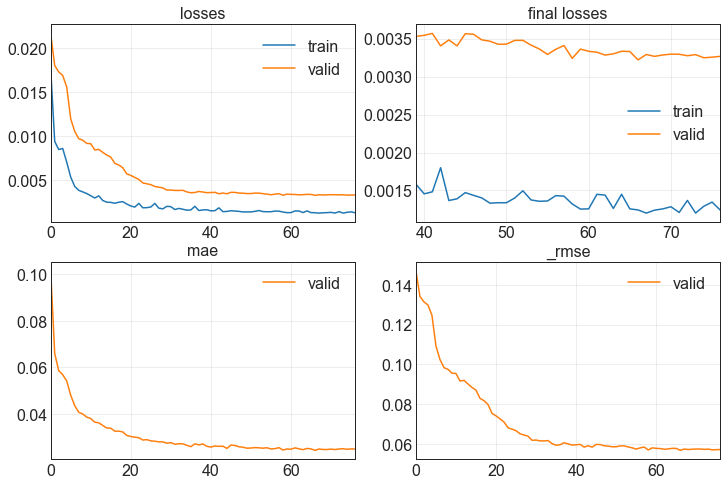

243.79749655723572                                                                                                     
[0.00124022935051471, 0.0032674798276275396, 0.025040116161108017, 0.05716187506914139]                                
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 100, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 1, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 10}
LSTM                                                                                                                   
 65%|█████████████████████████▎             | 65/100 [1:43:59<1:26:15, 147.86s/trial, best loss: 0.0032674798276275396]

No improvement since epoch 77: early stopping                                                                          
 65%|█████████████████████████▎             | 65/100 [1:48:48<1:26:15, 147.86s/trial, best loss: 0.0032674798276275396]

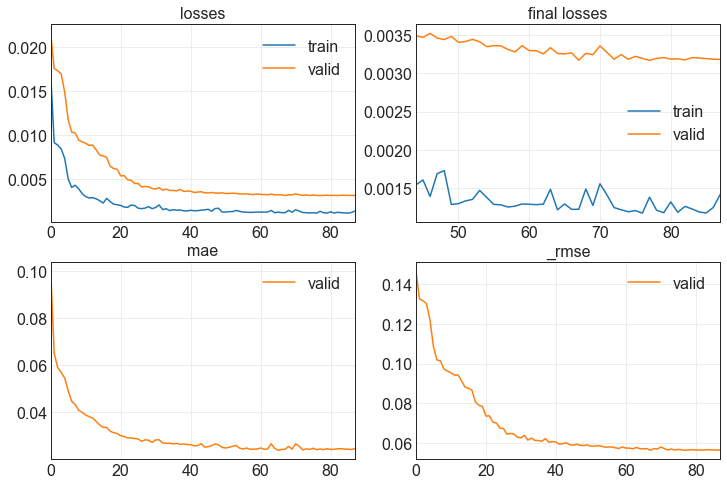

289.4048912525177                                                                                                      
[0.0014220521552488208, 0.0031821681186556816, 0.024669112637639046, 0.056410711258649826]                             
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 100, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 1, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 10}
LSTM                                                                                                                   
 66%|█████████████████████████▋             | 66/100 [1:48:50<1:48:05, 190.75s/trial, best loss: 0.0031821681186556816]

No improvement since epoch 85: early stopping                                                                          
 66%|█████████████████████████▋             | 66/100 [1:54:04<1:48:05, 190.75s/trial, best loss: 0.0031821681186556816]

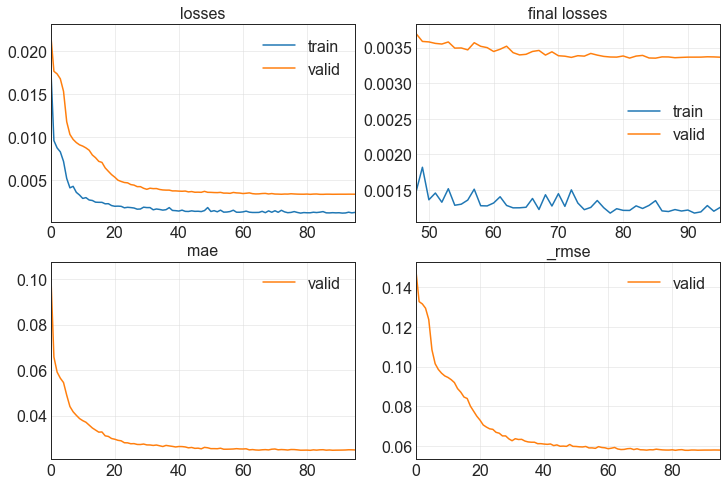

314.0959496498108                                                                                                      
[0.001257220865227282, 0.003366102697327733, 0.024880852550268173, 0.058018118143081665]                               
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 100, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 1, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 10}
LSTM                                                                                                                   
 67%|██████████████████████████▏            | 67/100 [1:54:06<2:05:32, 228.26s/trial, best loss: 0.0031821681186556816]

No improvement since epoch 81: early stopping                                                                          
 67%|██████████████████████████▏            | 67/100 [1:59:17<2:05:32, 228.26s/trial, best loss: 0.0031821681186556816]

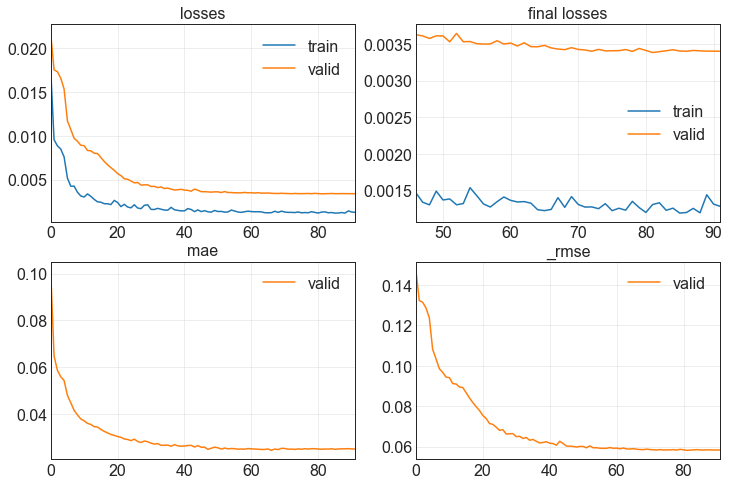

311.64542865753174                                                                                                     
[0.001280984841287136, 0.0034004298504441977, 0.025096625089645386, 0.05831320211291313]                               
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 100, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 1, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 10}
LSTM                                                                                                                   
 68%|██████████████████████████▌            | 68/100 [1:59:19<2:15:19, 253.74s/trial, best loss: 0.0031821681186556816]

No improvement since epoch 75: early stopping                                                                          
 68%|██████████████████████████▌            | 68/100 [2:03:54<2:15:19, 253.74s/trial, best loss: 0.0031821681186556816]

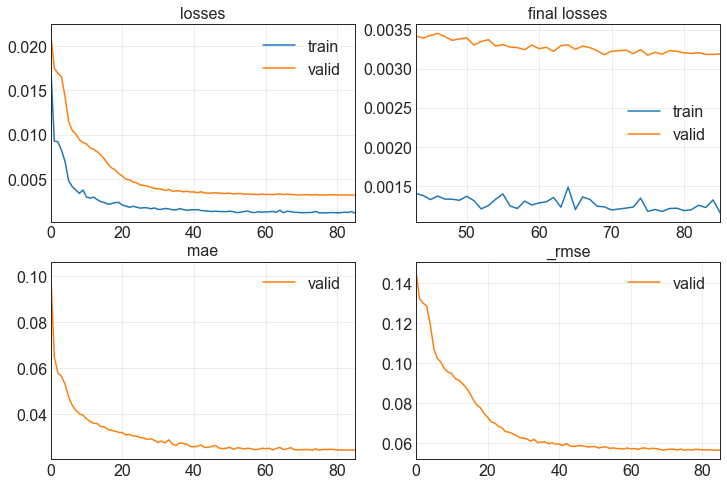

274.6583261489868                                                                                                      
[0.0011504144640639424, 0.003189342562109232, 0.024551015347242355, 0.05647427588701248]                               
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 100, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 1, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 10}
LSTM                                                                                                                   
 69%|██████████████████████████▉            | 69/100 [2:03:55<2:14:34, 260.48s/trial, best loss: 0.0031821681186556816]

No improvement since epoch 69: early stopping                                                                          
 69%|██████████████████████████▉            | 69/100 [2:08:07<2:14:34, 260.48s/trial, best loss: 0.0031821681186556816]

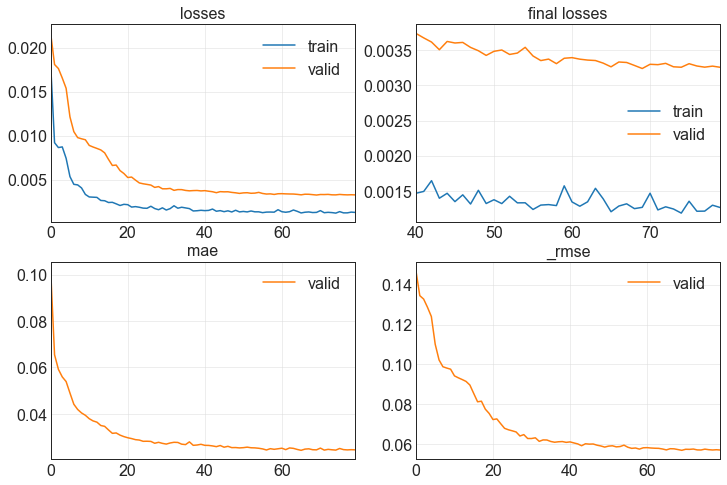

251.53634309768677                                                                                                     
[0.0012631567660719156, 0.0032569379545748234, 0.024500595405697823, 0.05706958845257759]                              
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 100, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 1, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 10}
LSTM                                                                                                                   
 70%|███████████████████████████▎           | 70/100 [2:08:08<2:09:07, 258.23s/trial, best loss: 0.0031821681186556816]

No improvement since epoch 56: early stopping                                                                          
 70%|███████████████████████████▎           | 70/100 [2:11:52<2:09:07, 258.23s/trial, best loss: 0.0031821681186556816]

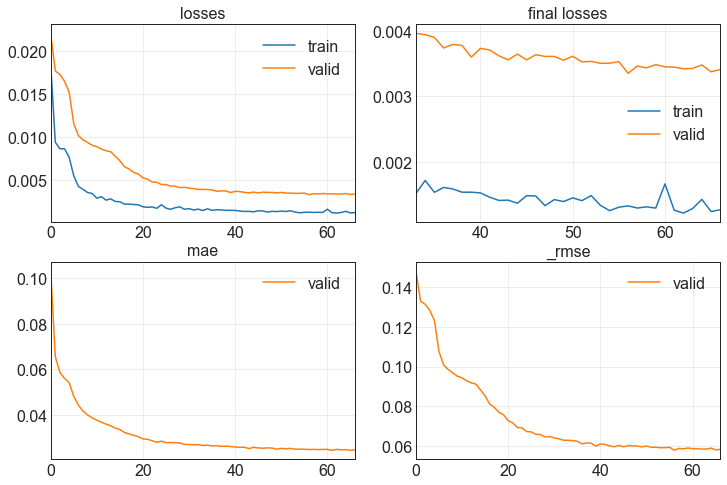

224.09868717193604                                                                                                     
[0.0012667878763750196, 0.003409448778256774, 0.02458568662405014, 0.058390483260154724]                               
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 100, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 4, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 10}
LSTM                                                                                                                   
 71%|███████████████████████████▋           | 71/100 [2:11:54<2:00:04, 248.42s/trial, best loss: 0.0031821681186556816]

No improvement since epoch 51: early stopping                                                                          
 71%|███████████████████████████▋           | 71/100 [2:19:29<2:00:04, 248.42s/trial, best loss: 0.0031821681186556816]

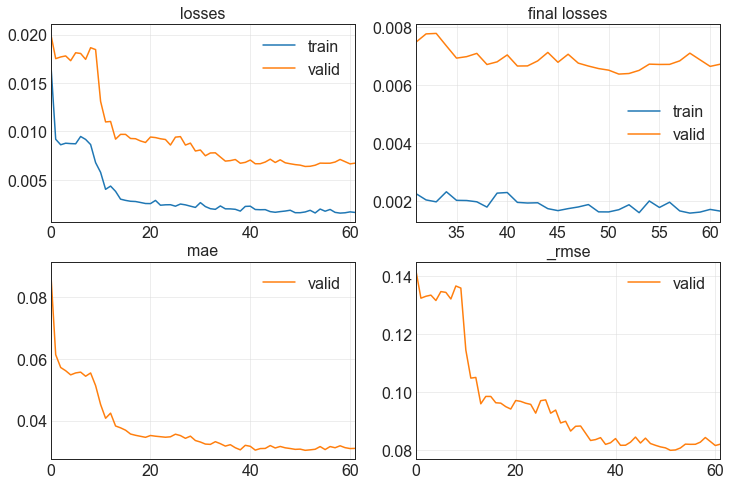

455.61253666877747                                                                                                     
[0.001640594331547618, 0.006729167886078358, 0.030960937961935997, 0.0820315033197403]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 100, 'hidden_size': 200, 'lr': 0.0001, 'n_layers': 1, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 10}
LSTM                                                                                                                   
 72%|████████████████████████████           | 72/100 [2:19:31<2:25:08, 311.01s/trial, best loss: 0.0031821681186556816]

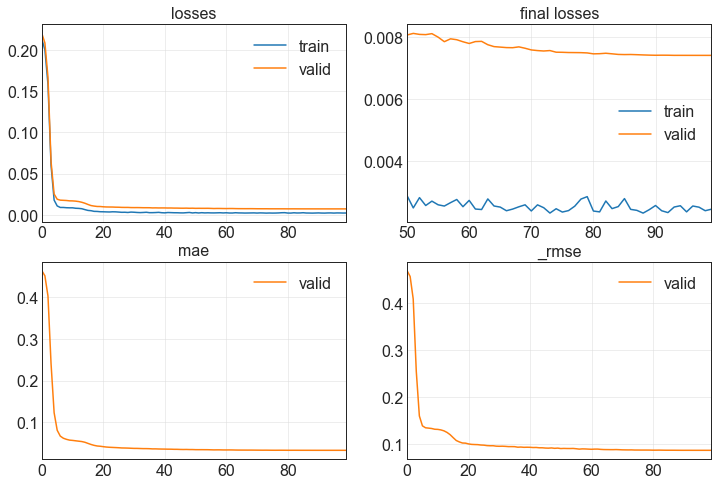

321.07198882102966                                                                                                     
[0.002433291869238019, 0.0074129593558609486, 0.03343292698264122, 0.08609854429960251]                                
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 100, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 3, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 10}
LSTM                                                                                                                   
 73%|████████████████████████████▍          | 73/100 [2:24:54<2:21:31, 314.50s/trial, best loss: 0.0031821681186556816]

No improvement since epoch 37: early stopping                                                                          
 73%|████████████████████████████▍          | 73/100 [2:29:26<2:21:31, 314.50s/trial, best loss: 0.0031821681186556816]

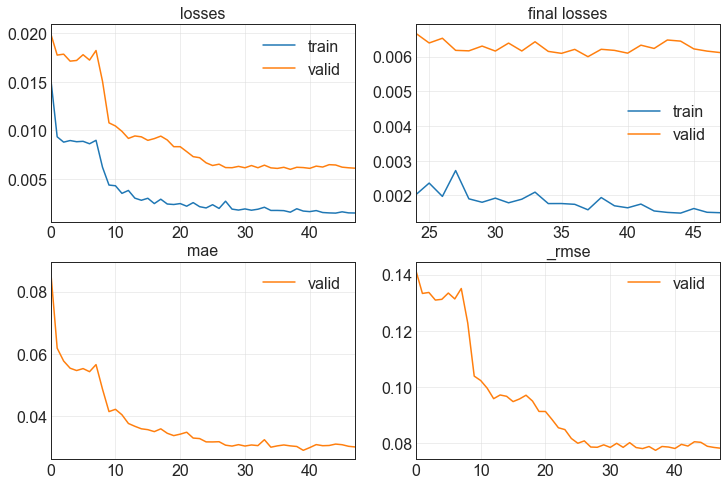

272.81757378578186                                                                                                     
[0.0015019347192719579, 0.006116306409239769, 0.030220309272408485, 0.07820682227611542]                               
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 100, 'hidden_size': 100, 'lr': 0.001, 'n_layers': 5, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 10}
LSTM                                                                                                                   
 74%|████████████████████████████▊          | 74/100 [2:29:28<2:11:03, 302.43s/trial, best loss: 0.0031821681186556816]

No improvement since epoch 26: early stopping                                                                          
 74%|████████████████████████████▊          | 74/100 [2:33:44<2:11:03, 302.43s/trial, best loss: 0.0031821681186556816]

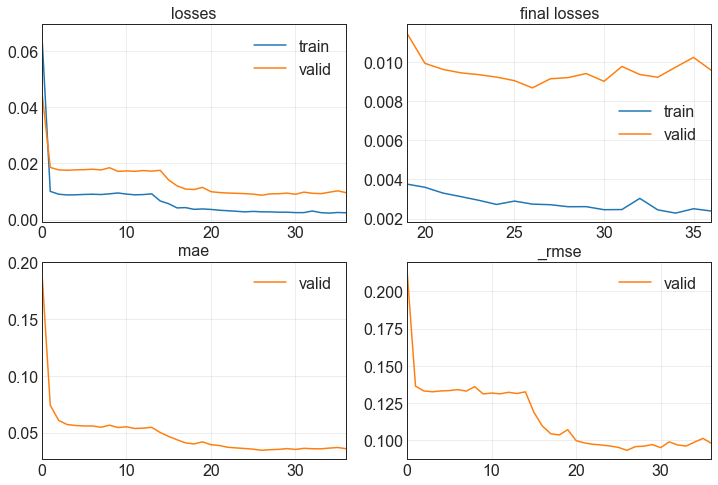

256.21782541275024                                                                                                     
[0.002390822395682335, 0.009563627652823925, 0.03579358756542206, 0.097793810069561]                                   
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 50, 'hidden_size': 200, 'lr': 0.0001, 'n_layers': 1, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 10}
LSTM                                                                                                                   
 75%|█████████████████████████████▎         | 75/100 [2:33:45<2:00:24, 288.98s/trial, best loss: 0.0031821681186556816]

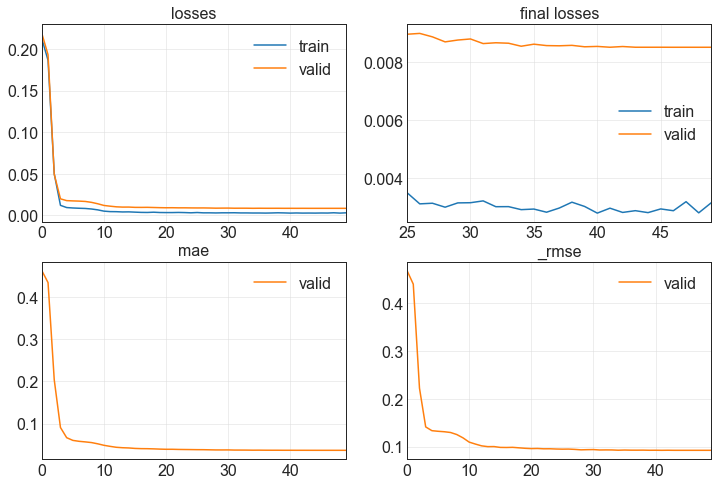

155.9545283317566                                                                                                      
[0.0031442600302398205, 0.008528018370270729, 0.0365709625184536, 0.09234727174043655]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 100, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 1, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 10}
LSTM                                                                                                                   
 76%|█████████████████████████████▋         | 76/100 [2:36:23<1:39:47, 249.49s/trial, best loss: 0.0031821681186556816]

No improvement since epoch 68: early stopping                                                                          
 76%|█████████████████████████████▋         | 76/100 [2:40:30<1:39:47, 249.49s/trial, best loss: 0.0031821681186556816]

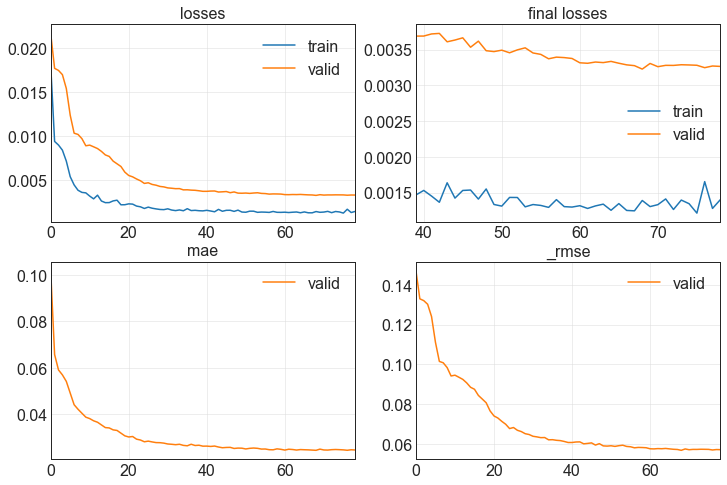

247.42059993743896                                                                                                     
[0.001399792032316327, 0.003265784587711096, 0.02448914758861065, 0.05714704468846321]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 100, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 4, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 10}
LSTM                                                                                                                   
 77%|██████████████████████████████         | 77/100 [2:40:32<1:35:33, 249.28s/trial, best loss: 0.0031821681186556816]

No improvement since epoch 28: early stopping                                                                          
 77%|██████████████████████████████         | 77/100 [2:45:06<1:35:33, 249.28s/trial, best loss: 0.0031821681186556816]

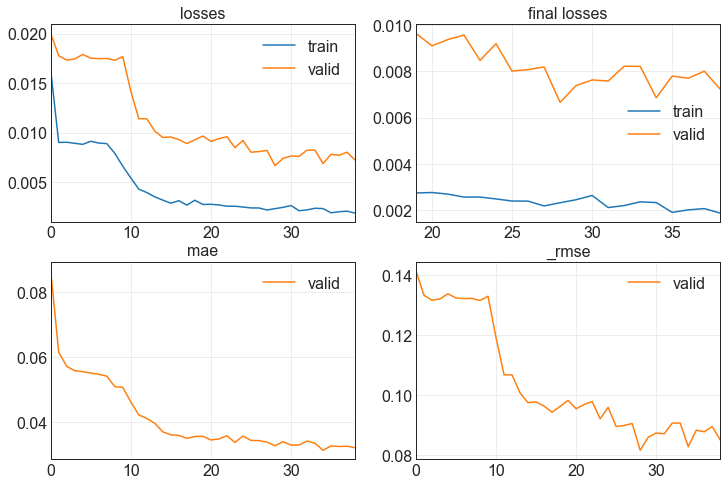

274.79551911354065                                                                                                     
[0.001864776248112321, 0.007226994726806879, 0.032030873000621796, 0.08501173555850983]                                
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 100, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 3, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 10}
LSTM                                                                                                                   
 78%|██████████████████████████████▍        | 78/100 [2:45:08<1:34:22, 257.38s/trial, best loss: 0.0031821681186556816]

No improvement since epoch 38: early stopping                                                                          
 78%|██████████████████████████████▍        | 78/100 [2:49:51<1:34:22, 257.38s/trial, best loss: 0.0031821681186556816]

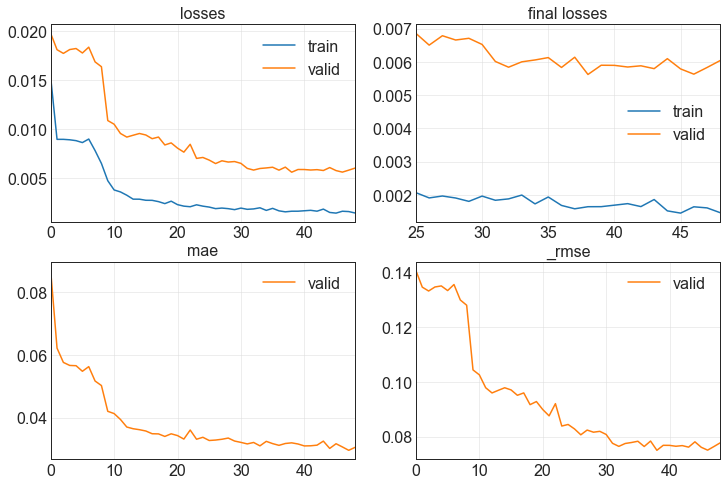

283.5280499458313                                                                                                      
[0.0014667196664959192, 0.006042523309588432, 0.030536245554685593, 0.07773366570472717]                               
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': False, 'epochs': 100, 'hidden_size': 100, 'lr': 0.001, 'n_layers': 1, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 10}
LSTM                                                                                                                   
 79%|██████████████████████████████▊        | 79/100 [2:49:53<1:32:58, 265.65s/trial, best loss: 0.0031821681186556816]

No improvement since epoch 65: early stopping                                                                          
 79%|██████████████████████████████▊        | 79/100 [2:53:11<1:32:58, 265.65s/trial, best loss: 0.0031821681186556816]

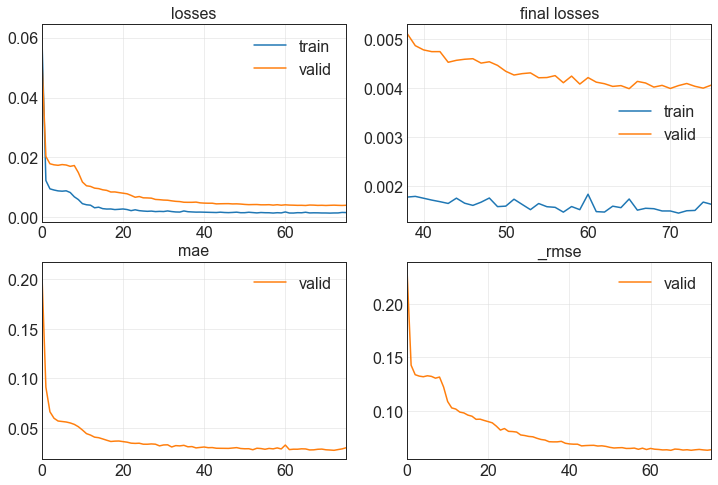

198.0676290988922                                                                                                      
[0.001633911277167499, 0.004068648908287287, 0.029846230521798134, 0.06378595530986786]                                
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 50, 'hidden_size': 200, 'lr': 0.0001, 'n_layers': 5, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 10}
LSTM                                                                                                                   
 80%|███████████████████████████████▏       | 80/100 [2:53:13<1:21:56, 245.84s/trial, best loss: 0.0031821681186556816]

No improvement since epoch 9: early stopping                                                                           
 80%|███████████████████████████████▏       | 80/100 [2:56:00<1:21:56, 245.84s/trial, best loss: 0.0031821681186556816]

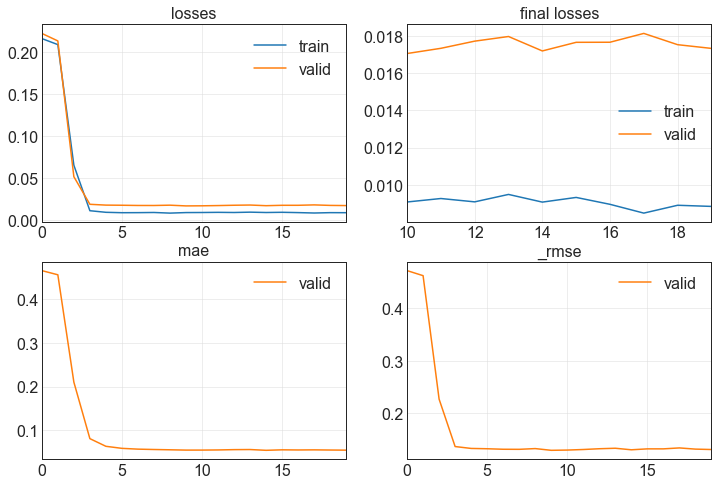

167.17281198501587                                                                                                     
[0.008846432901918888, 0.017325224354863167, 0.05426325649023056, 0.13162532448768616]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 100, 'hidden_size': 50, 'lr': 0.001, 'n_layers': 1, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 10}
LSTM                                                                                                                   
 81%|███████████████████████████████▌       | 81/100 [2:56:01<1:10:32, 222.76s/trial, best loss: 0.0031821681186556816]

No improvement since epoch 80: early stopping                                                                          
 81%|███████████████████████████████▌       | 81/100 [3:00:39<1:10:32, 222.76s/trial, best loss: 0.0031821681186556816]

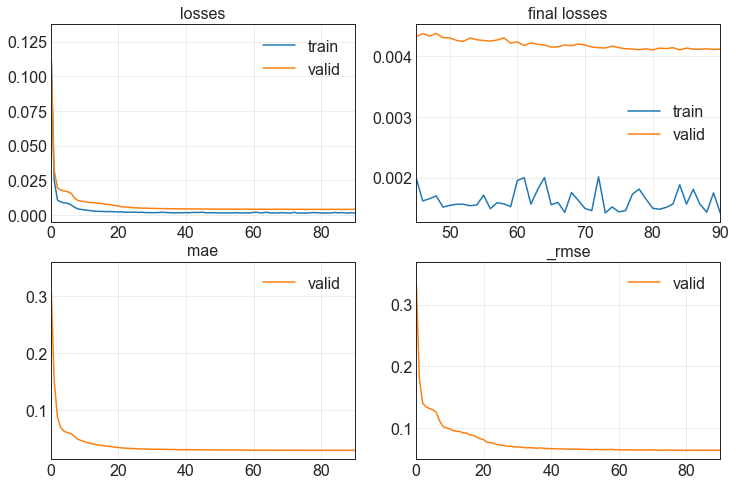

277.6625201702118                                                                                                      
[0.0014153351075947285, 0.004113428294658661, 0.028513725847005844, 0.06413601338863373]                               
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': True, 'epochs': 100, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 1, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 10}
LSTM                                                                                                                   
 82%|███████████████████████████████▉       | 82/100 [3:00:41<1:11:53, 239.66s/trial, best loss: 0.0031821681186556816]

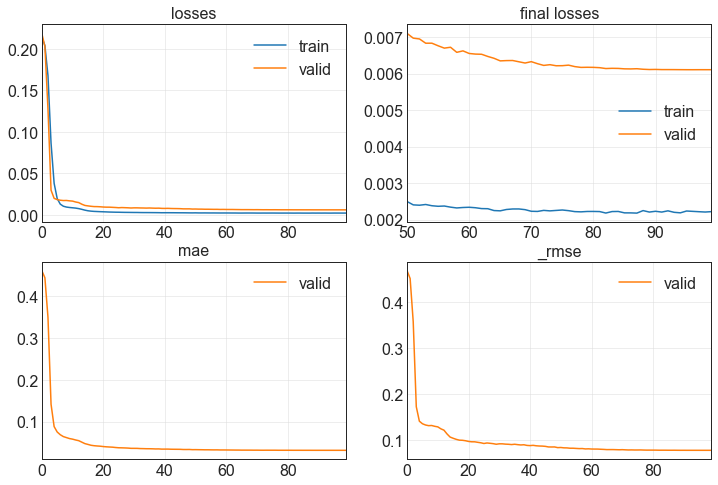

54.74170637130737                                                                                                      
[0.0022190215531736612, 0.006110167130827904, 0.03144136071205139, 0.07816755771636963]                                
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': False, 'epochs': 100, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 4, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 10}
LSTM                                                                                                                   
 83%|██████████████████████████████████       | 83/100 [3:01:37<52:18, 184.64s/trial, best loss: 0.0031821681186556816]

No improvement since epoch 38: early stopping                                                                          
 83%|██████████████████████████████████       | 83/100 [3:05:31<52:18, 184.64s/trial, best loss: 0.0031821681186556816]

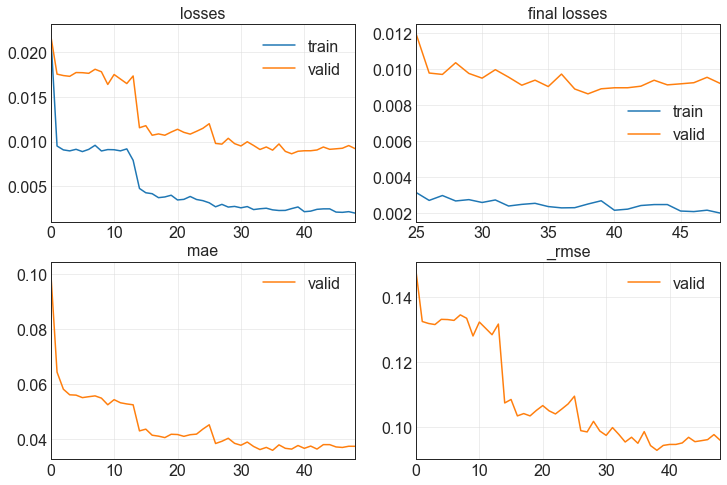

235.19004821777344                                                                                                     
[0.001997691113501787, 0.009205136448144913, 0.03735791891813278, 0.0959434062242508]                                  
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 100, 'hidden_size': 100, 'lr': 0.0001, 'n_layers': 1, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 10}
LSTM                                                                                                                   
 84%|██████████████████████████████████▍      | 84/100 [3:05:33<53:23, 200.24s/trial, best loss: 0.0031821681186556816]

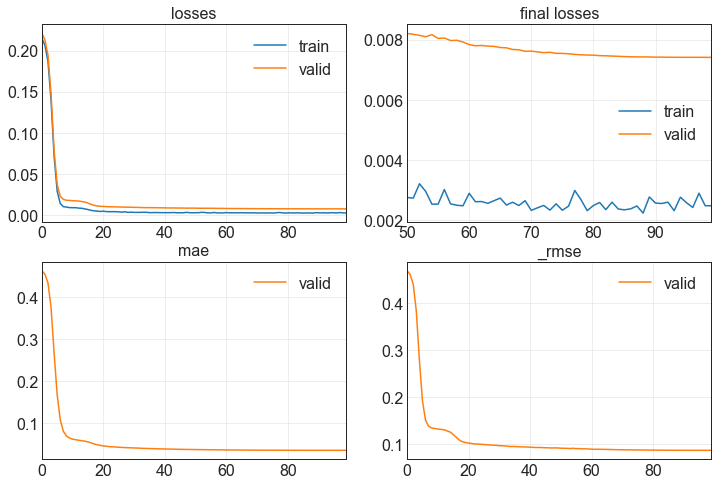

310.5834300518036                                                                                                      
[0.002475133165717125, 0.0074113463051617146, 0.03434408828616142, 0.08608918637037277]                                
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': True, 'epochs': 50, 'hidden_size': 50, 'lr': 0.001, 'n_layers': 3, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 10}
LSTM                                                                                                                   
 85%|██████████████████████████████████▊      | 85/100 [3:10:45<58:26, 233.77s/trial, best loss: 0.0031821681186556816]

No improvement since epoch 17: early stopping                                                                          
 85%|██████████████████████████████████▊      | 85/100 [3:11:23<58:26, 233.77s/trial, best loss: 0.0031821681186556816]

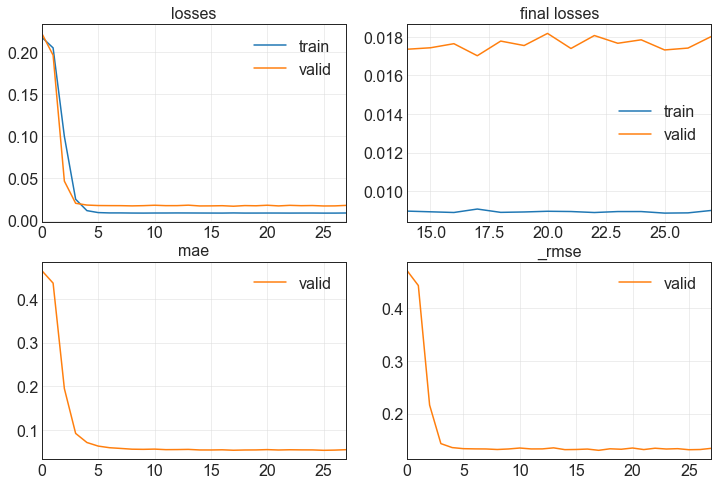

38.00471115112305                                                                                                      
[0.009002577513456345, 0.018015805631875992, 0.055272769182920456, 0.13422295451164246]                                
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 100, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 1, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 10}
LSTM                                                                                                                   
 86%|███████████████████████████████████▎     | 86/100 [3:11:25<40:56, 175.48s/trial, best loss: 0.0031821681186556816]

No improvement since epoch 72: early stopping                                                                          
 86%|███████████████████████████████████▎     | 86/100 [3:15:54<40:56, 175.48s/trial, best loss: 0.0031821681186556816]

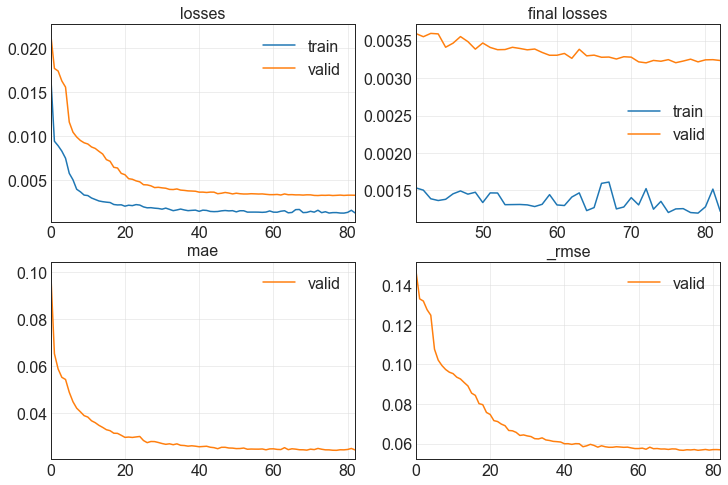

269.40165734291077                                                                                                     
[0.0012199587654322386, 0.0032342139165848494, 0.024468284100294113, 0.056870147585868835]                             
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 100, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 5, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 10}
LSTM                                                                                                                   
 87%|███████████████████████████████████▋     | 87/100 [3:15:56<44:13, 204.08s/trial, best loss: 0.0031821681186556816]

No improvement since epoch 22: early stopping                                                                          
 87%|███████████████████████████████████▋     | 87/100 [3:20:45<44:13, 204.08s/trial, best loss: 0.0031821681186556816]

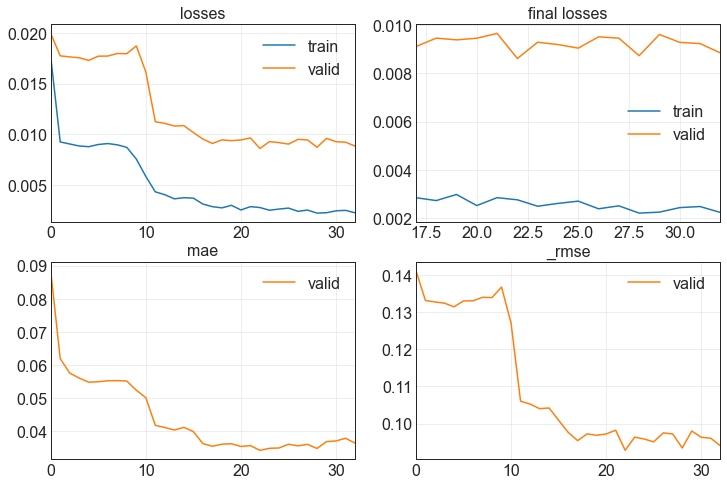

289.6084840297699                                                                                                      
[0.0022487177047878504, 0.008839312009513378, 0.03638370335102081, 0.09401761740446091]                                
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': False, 'epochs': 100, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 1, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 10}
LSTM                                                                                                                   
 88%|████████████████████████████████████     | 88/100 [3:20:47<46:02, 230.19s/trial, best loss: 0.0031821681186556816]

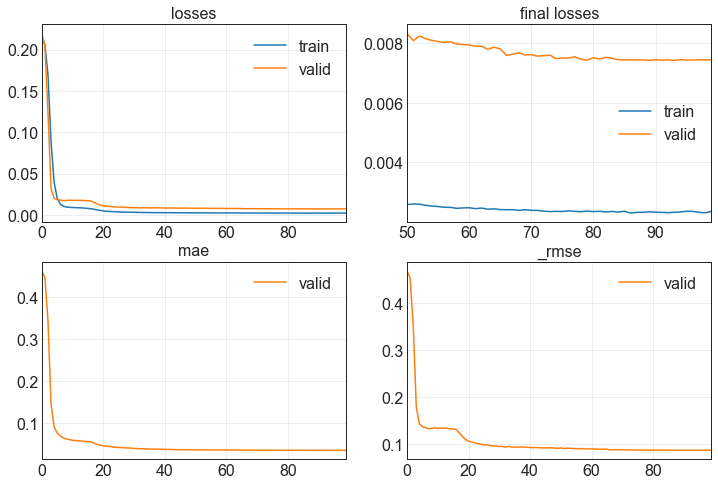

47.627299308776855                                                                                                     
[0.0023599464911967516, 0.0074385423213243484, 0.0346175879240036, 0.08624698221683502]                                
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 100, 'hidden_size': 50, 'lr': 0.0001, 'n_layers': 1, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 10}
LSTM                                                                                                                   
 89%|████████████████████████████████████▍    | 89/100 [3:21:36<32:14, 175.86s/trial, best loss: 0.0031821681186556816]

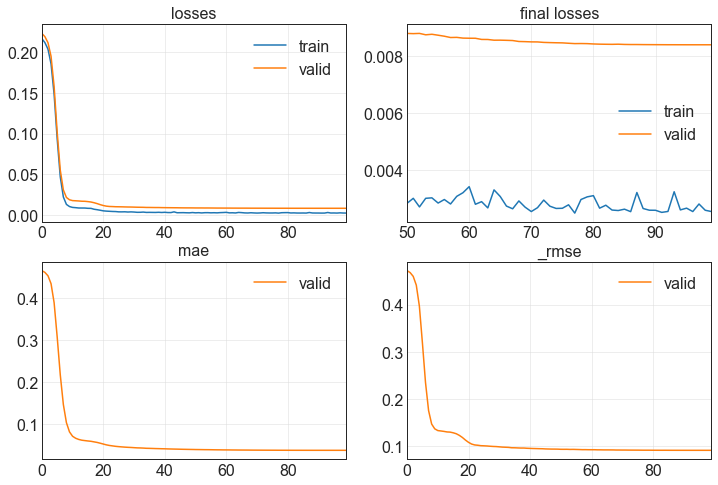

319.7713086605072                                                                                                      
[0.00253723980858922, 0.008403483778238297, 0.0372978150844574, 0.09167052805423737]                                   
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 50, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 1, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 10}
LSTM                                                                                                                   
 90%|████████████████████████████████████▉    | 90/100 [3:26:57<36:34, 219.49s/trial, best loss: 0.0031821681186556816]

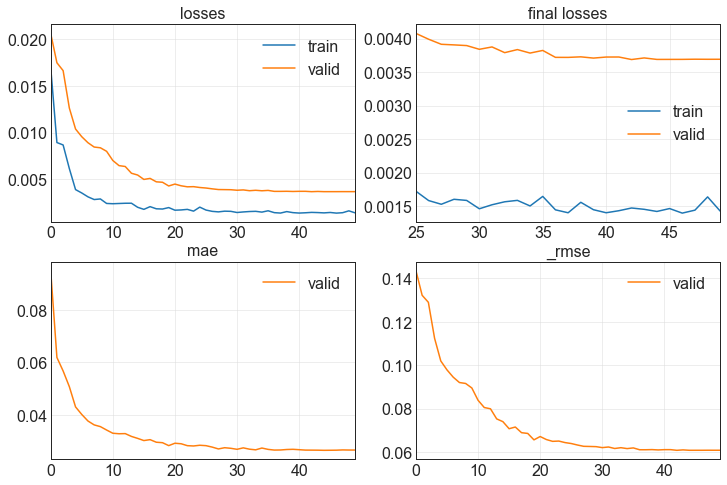

170.59685897827148                                                                                                     
[0.0014234750997275114, 0.003692836035043001, 0.026662008836865425, 0.06076871231198311]                               
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': True, 'epochs': 20, 'hidden_size': 100, 'lr': 0.001, 'n_layers': 4, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 10}
LSTM                                                                                                                   
 91%|█████████████████████████████████████▎   | 91/100 [3:29:49<30:47, 205.31s/trial, best loss: 0.0031821681186556816]

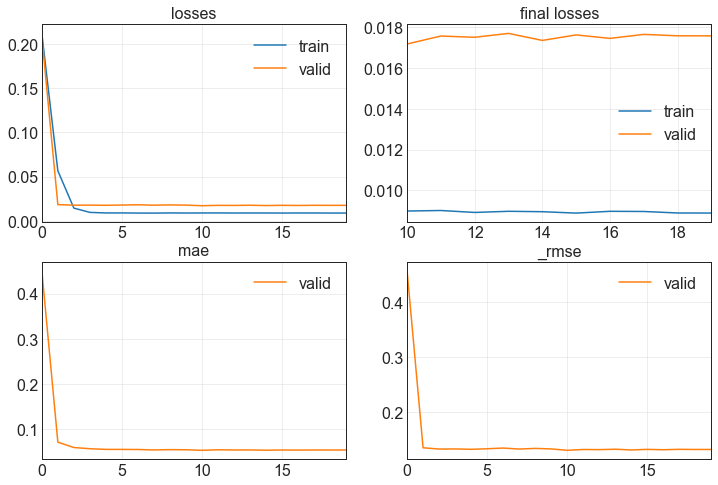

39.94852876663208                                                                                                      
[0.008893941529095173, 0.017575599253177643, 0.05454253777861595, 0.1325729936361313]                                  
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': False, 'epochs': 100, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 3, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 5}
LSTM                                                                                                                   
 92%|█████████████████████████████████████▋   | 92/100 [3:30:31<20:49, 156.17s/trial, best loss: 0.0031821681186556816]

No improvement since epoch 51: early stopping                                                                          
 92%|█████████████████████████████████████▋   | 92/100 [3:34:23<20:49, 156.17s/trial, best loss: 0.0031821681186556816]

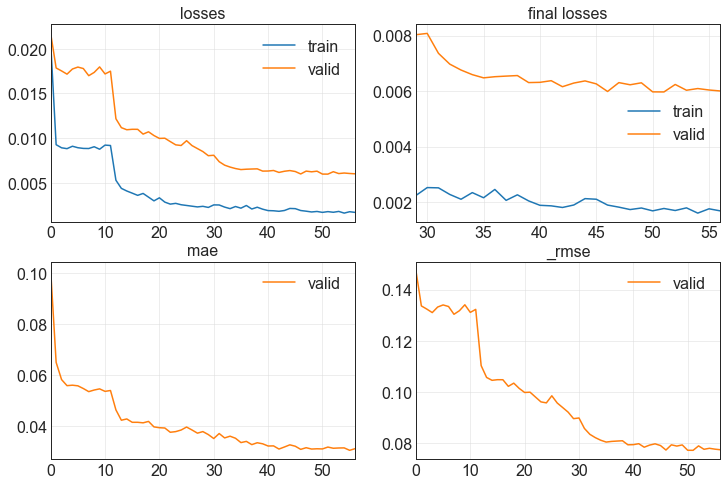

232.1033182144165                                                                                                      
[0.0016831880202516913, 0.006004699040204287, 0.03125671669840813, 0.07748997211456299]                                
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': True, 'epochs': 100, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 1, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 10}
LSTM                                                                                                                   
 93%|██████████████████████████████████████▏  | 93/100 [3:34:25<20:55, 179.41s/trial, best loss: 0.0031821681186556816]

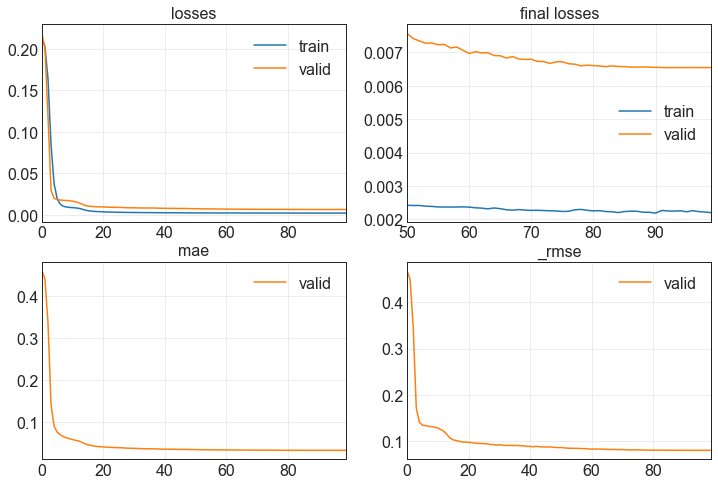

56.39245676994324                                                                                                      
[0.002200089395046234, 0.006544274743646383, 0.031957220286130905, 0.08089669793844223]                                
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 100, 'hidden_size': 200, 'lr': 0.0001, 'n_layers': 5, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 10}
LSTM                                                                                                                   
 94%|██████████████████████████████████████▌  | 94/100 [3:35:23<14:17, 142.96s/trial, best loss: 0.0031821681186556816]

No improvement since epoch 11: early stopping                                                                          
 94%|██████████████████████████████████████▌  | 94/100 [3:38:38<14:17, 142.96s/trial, best loss: 0.0031821681186556816]

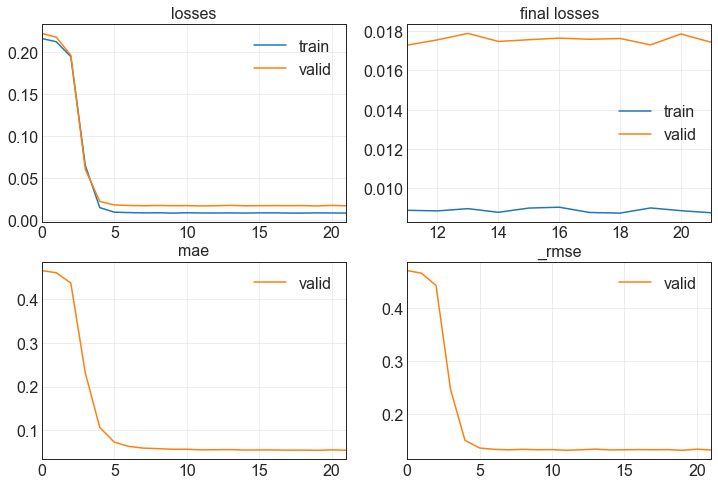

195.9353187084198                                                                                                      
[0.008762490004301071, 0.01742512919008732, 0.054282307624816895, 0.1320042759180069]                                  
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 20, 'hidden_size': 50, 'lr': 0.001, 'n_layers': 1, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 10}
LSTM                                                                                                                   
 95%|██████████████████████████████████████▉  | 95/100 [3:38:40<13:16, 159.33s/trial, best loss: 0.0031821681186556816]

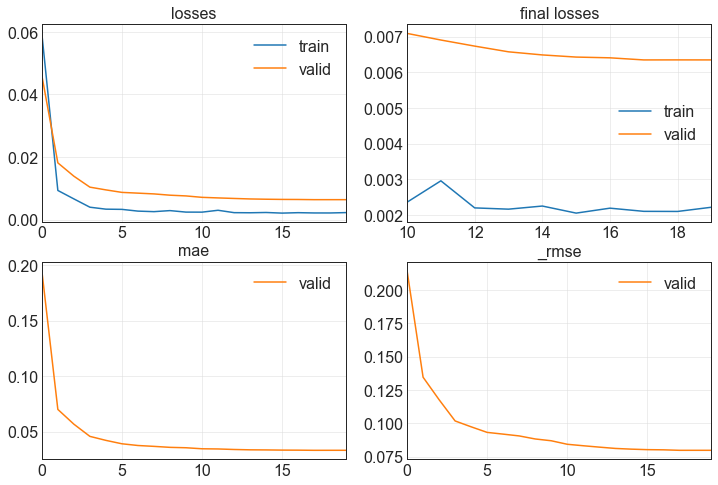

65.38374090194702                                                                                                      
[0.002213889267295599, 0.006346668116748333, 0.03307484835386276, 0.07966598123311996]                                 
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': True, 'epochs': 100, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 2, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 5}
LSTM                                                                                                                   
 96%|███████████████████████████████████████▎ | 96/100 [3:39:47<08:46, 131.58s/trial, best loss: 0.0031821681186556816]

No improvement since epoch 5: early stopping                                                                           
 96%|███████████████████████████████████████▎ | 96/100 [3:40:02<08:46, 131.58s/trial, best loss: 0.0031821681186556816]

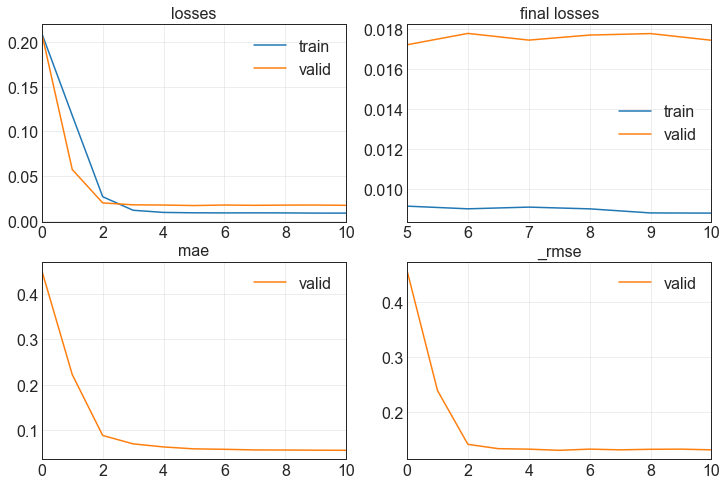

15.660720825195312                                                                                                     
[0.00877661257982254, 0.0174585971981287, 0.05583202838897705, 0.13213098049163818]                                    
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': False, 'epochs': 50, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 10}
LSTM                                                                                                                   
 97%|████████████████████████████████████████▋ | 97/100 [3:40:04<04:51, 97.27s/trial, best loss: 0.0031821681186556816]

No improvement since epoch 22: early stopping                                                                          
 97%|████████████████████████████████████████▋ | 97/100 [3:41:29<04:51, 97.27s/trial, best loss: 0.0031821681186556816]

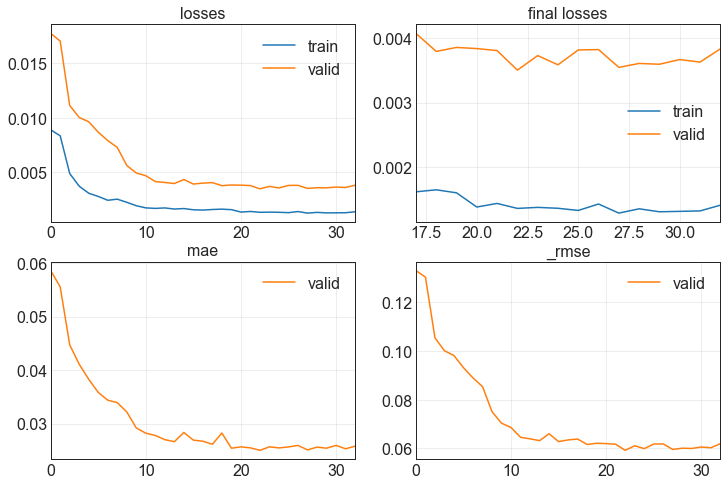

85.35649490356445                                                                                                      
[0.001408757409080863, 0.0038349584210664034, 0.025782227516174316, 0.061927035450935364]                              
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': True, 'epochs': 100, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 1, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 10}
LSTM                                                                                                                   
 98%|█████████████████████████████████████████▏| 98/100 [3:41:31<03:08, 94.13s/trial, best loss: 0.0031821681186556816]

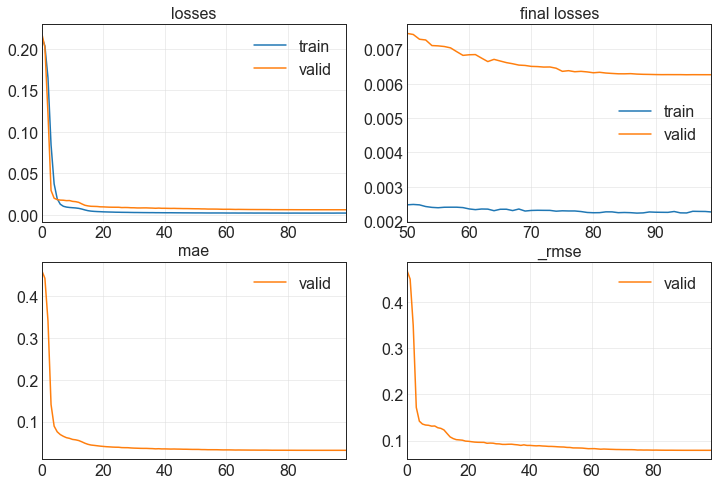

57.704426288604736                                                                                                     
[0.0022667478770017624, 0.006263343151658773, 0.031456414610147476, 0.0791412815451622]                                
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 100, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 4, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 10}
LSTM                                                                                                                   
 99%|█████████████████████████████████████████▌| 99/100 [3:42:30<01:23, 83.64s/trial, best loss: 0.0031821681186556816]

No improvement since epoch 46: early stopping                                                                          
 99%|█████████████████████████████████████████▌| 99/100 [3:49:33<01:23, 83.64s/trial, best loss: 0.0031821681186556816]

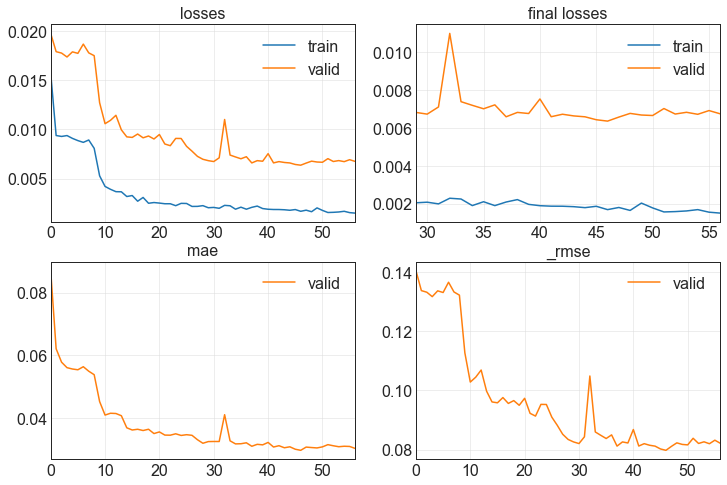

423.7218520641327                                                                                                      
[0.0014997010584920645, 0.006748788058757782, 0.030238594859838486, 0.08215101063251495]                               
100%|████████████████████████████████████████| 100/100 [3:49:34<00:00, 137.74s/trial, best loss: 0.0031821681186556816]


In [57]:
trials = Trials()
best = fmin(create_model_hypopt,
    space=search_space,
    algo=tpe.suggest,
    max_evals=max_evals,  # test trials
    trials=trials)

In [58]:
print("Best parameters:")
print(space_eval(search_space, best))
params = space_eval(search_space, best)

Best parameters:
{'batch_size': 16, 'bidirectional': True, 'epochs': 100, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 1, 'optimizer': <function Adam at 0x000001C0D8123438>, 'patience': 10}


In [59]:
# only for debug
# params = {'batch_size': 16, 'bidirectional': False, 'epochs': 20, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 5, 'optimizer': Adam, 'patience': 10}

# Retrain the model with best hyperparameter

We use training data for training and validation data for (possible) early stopping:

In [60]:
X, y, splits = combine_split_data([X_train, X_valid], [y_train, y_valid])

In [61]:
X.shape

(8606, 529, 10)

In [62]:
y.shape

(8606, 529)

In [63]:
batch_size = params["batch_size"]

In [64]:
tfms  = [None, [TSRegression()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
# set num_workers for memory bottleneck
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[batch_size, batch_size], num_workers=0)

Create the model:

In [65]:
arch = LSTM
k = {
    'n_layers': params['n_layers'],
    'hidden_size': params['hidden_size'],
    'bidirectional': params['bidirectional']
}
model = create_model(arch, dls=dls, **k)
print(model.__class__.__name__)

LSTM


In [66]:
model

LSTM(
  (rnn): LSTM(529, 200, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=400, out_features=529, bias=True)
)

In [67]:
# Add a Sigmoid layer
model = nn.Sequential(model, nn.Sigmoid())

In [68]:
model

Sequential(
  (0): LSTM(
    (rnn): LSTM(529, 200, batch_first=True, bidirectional=True)
    (fc): Linear(in_features=400, out_features=529, bias=True)
  )
  (1): Sigmoid()
)

In [69]:
# Find total parameters and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

1,381,729 total parameters.
1,381,729 training parameters.


Training the model:

No improvement since epoch 67: early stopping


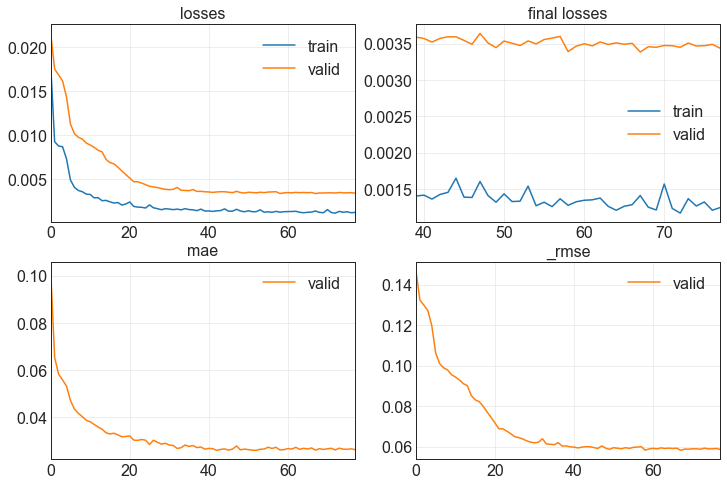

In [70]:
learn = Learner(dls, model, metrics=[mae, rmse], opt_func=params['optimizer'])
start = time.time()
learn.fit_one_cycle(params['epochs'], lr_max=params['lr'],
                    cbs=EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0, patience=params['patience']))
training_time = time.time() - start
learn.plot_metrics()

Evaluate the model:

In [71]:
dls = learn.dls
valid_dl = dls.valid

In [72]:
test_ds = valid_dl.dataset.add_test(X_test, y_test)  # use the test data
test_dl = valid_dl.new(test_ds)
print(test_dl.n)

2153


In [73]:
start = time.time()
test_probas, test_targets, test_preds = learn.get_preds(dl=test_dl, with_decoded=True, save_preds=None, save_targs=None)
prediction_time = time.time() - start
test_probas, test_targets, test_preds

(tensor([[0.0030, 0.0569, 0.0166,  ..., 0.0042, 0.0043, 0.0020],
         [0.0030, 0.0516, 0.0159,  ..., 0.0041, 0.0041, 0.0019],
         [0.0030, 0.0516, 0.0154,  ..., 0.0042, 0.0040, 0.0019],
         ...,
         [0.0035, 0.0350, 0.0234,  ..., 0.0041, 0.0045, 0.0020],
         [0.0035, 0.0333, 0.0257,  ..., 0.0041, 0.0045, 0.0020],
         [0.0036, 0.0338, 0.0251,  ..., 0.0041, 0.0046, 0.0021]]),
 tensor([[0.0000e+00, 4.2537e-04, 9.6929e-04,  ..., 4.5983e-04, 1.2533e-04,
          0.0000e+00],
         [0.0000e+00, 1.6241e-04, 3.8517e-04,  ..., 5.4193e-04, 8.0880e-05,
          0.0000e+00],
         [0.0000e+00, 2.2912e-04, 1.9301e-03,  ..., 4.0765e-04, 1.9965e-04,
          0.0000e+00],
         ...,
         [0.0000e+00, 4.7334e-03, 0.0000e+00,  ..., 1.2775e-03, 0.0000e+00,
          0.0000e+00],
         [0.0000e+00, 6.2943e-03, 0.0000e+00,  ..., 1.1132e-03, 2.1495e-04,
          0.0000e+00],
         [0.0000e+00, 1.3714e-02, 0.0000e+00,  ..., 1.7625e-04, 0.0000e+00,
         

In [74]:
test_targets.shape

torch.Size([2153, 529])

In [75]:
test_preds.shape

torch.Size([2153, 529])

In [76]:
y_true = test_targets.numpy()
y_pred = test_preds.numpy()

Reshape the data into multiple steps

In [77]:
y_true = y_true.reshape(y_true.shape[0], horizon, -1)
y_pred = y_pred.reshape(y_pred.shape[0], horizon, -1)

In [78]:
y_true.shape

(2153, 1, 529)

In [79]:
y_pred.shape

(2153, 1, 529)

Transform the data in the normal range:

In [80]:
def inverse_normalization(prediction, y, max_list, min_list):
    inverse_prediction = prediction * (max_list - min_list) + min_list
    inverse_y = y * (max_list - min_list) + min_list

    return inverse_prediction, inverse_y

In [81]:
y_true_list = []
y_pred_list = []
for i in range(y_true.shape[0]):
    y_true_tmp = []
    y_pred_tmp = []
    for step in range(y_true.shape[1]):
        inverse_prediction, inverse_y = inverse_normalization(y_pred[i, step, :], y_true[i, step, :], max_list, min_list)
        
        y_true_tmp.append(inverse_y)
        y_pred_tmp.append(inverse_prediction)
    y_true_list.append(y_true_tmp)
    y_pred_list.append(y_pred_tmp)

In [82]:
y_true = np.array(y_true_list)
y_pred = np.array(y_pred_list)

In [83]:
y_true.shape

(2153, 1, 529)

In [84]:
y_pred.shape

(2153, 1, 529)

# Save Predictions and Evaluate Model

Save true values and predictions first:

In [85]:
pickle.dump(y_pred, open(y_pred_fn, 'wb'))

In [86]:
pickle.dump(y_true, open(y_true_fn, 'wb'))

The training and test time spent:

In [87]:
print('Training time (in seconds): ', training_time)
print('Test time (in seconds): ', prediction_time)

Training time (in seconds):  262.1381251811981
Test time (in seconds):  0.6880314350128174


In [93]:
print('Training time (in seconds) per epoch: ', 262.1381251811981 / 78)

Training time (in seconds) per epoch:  3.360745194630745


Calculate the RMSE and MAE for differnt time steps:

In [89]:
for step in range(horizon):
    print('Prediction for the next %d frame' % (step + 1))
    print('RMSE: ', math.sqrt(mean_squared_error(y_true[:, step, :].flatten(), y_pred[:, step, :].flatten())) / 1000)  # in Mbps
    print('MAE: ', mean_absolute_error(y_true[:, step, :].flatten(), y_pred[:, step, :].flatten()) / 1000 )

Prediction for the next 1 frame
RMSE:  15.964229947311324
MAE:  6.066371507439798


Plot the RMSE and MAE distributions for each time step:

In [90]:
def plot_RMSE(y_true, y_pred, fn, xlim=60):
    RMSE_list = []

    for i in range(y_true.shape[0]):
        rmse = math.sqrt(mean_squared_error(y_true[i].flatten(), y_pred[i].flatten())) / 1000
        RMSE_list.append(rmse)
    
    data = RMSE_list
    data_size = len(data)
    data_set = sorted(set(data))
    bins = np.append(data_set, data_set[-1] + 1)

    # Use the histogram function to bin the data
    counts, bin_edges = np.histogram(data, bins=bins, density=False)
    counts = counts.astype(float) / data_size
    
    plt.figure(figsize=[12, 9])
    plt.xlabel("RMSE (Mbps)")
    plt.xlim((0, xlim))
    plt.ylabel("CDF")
    plt.ylim((0, 1))

    # Format the x tick labels
    ax = plt.gca()
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-1, 1))
    ax.xaxis.set_major_formatter(formatter)

    cdf = np.cumsum(counts)
    plt.plot(bin_edges[0:-1], cdf)
    
    plt.savefig(fn, bbox_inches = 'tight', pad_inches = 0.1)

In [91]:
def plot_MAE(y_true, y_pred, fn, xlim=60):
    MAE_list = []

    for i in range(y_true.shape[0]):
        mae = mean_absolute_error(y_true[i].flatten(), y_pred[i].flatten()) / 1000
        MAE_list.append(mae)
    
    data = MAE_list
    data_size = len(data)
    data_set = sorted(set(data))
    bins = np.append(data_set, data_set[-1] + 1)

    # Use the histogram function to bin the data
    counts, bin_edges = np.histogram(data, bins=bins, density=False)
    counts = counts.astype(float) / data_size
    
    plt.figure(figsize=[12, 9])
    plt.xlabel("MAE (Mbps)")
    plt.xlim((0, xlim))
    plt.ylabel("CDF")
    plt.ylim((0, 1))

    # Format the x tick labels
    ax = plt.gca()
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-1, 1))
    ax.xaxis.set_major_formatter(formatter)

    cdf = np.cumsum(counts)
    plt.plot(bin_edges[0:-1], cdf)
    
    plt.savefig(fn, bbox_inches = 'tight', pad_inches = 0.1)

LSTM_TM-minmax_RMSE-10-1-step-1.pdf
LSTM_TM-minmax_MAE-10-1-step-1.pdf


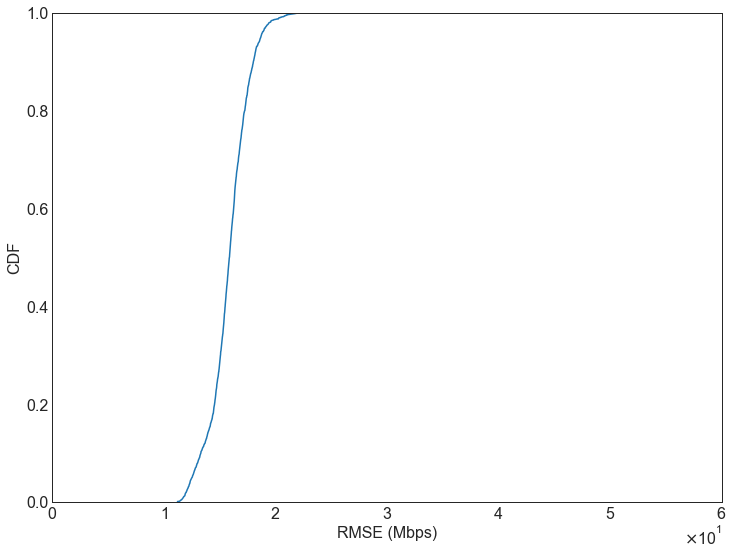

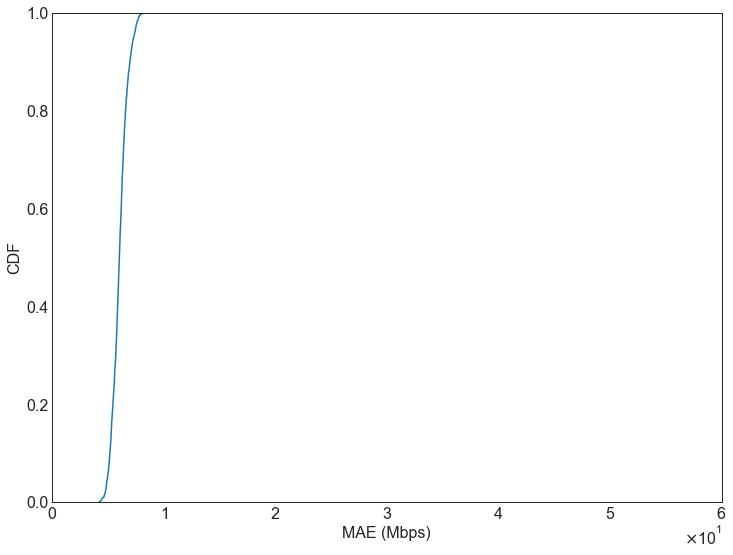

In [92]:
for step in range(horizon):
    fn = RMSE_fn % (history, horizon, step + 1)
    print(fn)
    
    plot_RMSE(y_true[:, step, :], y_pred[:, step, :], fn)
    
    fn = MAE_fn % (history, horizon, step + 1)
    print(fn)
    
    plot_MAE(y_true[:, step, :], y_pred[:, step, :], fn)